<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ IMPORTS ✨</span>
</div>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score
import pickle
from collections import defaultdict
from sklearn.utils import shuffle
import os
import cv2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd

from torchinfo import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns



In [2]:
import numpy as np
import os

# Define the folder path
folder_path = r"D:\PYTHONIG\newwindow\NOTEBOOKS_2025\aprilmay2025\data\numpy\melnormalized\concatenatedspectrograms"

# Load the numpy files into the respective arrays with the correct capitalized naming
eeg_fold_1 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_1.npy'))
labels_fold_1 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_1.npy'))
patients_fold_1 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_1.npy'))

eeg_fold_2 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_2.npy'))
labels_fold_2 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_2.npy'))
patients_fold_2 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_2.npy'))

eeg_fold_3 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_3.npy'))
labels_fold_3 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_3.npy'))
patients_fold_3 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_3.npy'))

eeg_fold_4 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_4.npy'))
labels_fold_4 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_4.npy'))
patients_fold_4 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_4.npy'))

eeg_fold_5 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_5.npy'))
labels_fold_5 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_5.npy'))
patients_fold_5 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_5.npy'))


# #generate random arrays for now
# eeg_fold_1 = np.random.rand(10, 224, 224,3)
# labels_fold_1 = np.random.randint(0, 3, 10)
# patients_fold_1 = np.random.randint(1, 11, 10)

# eeg_fold_2 = np.random.rand(10, 224, 224,3)
# labels_fold_2 = np.random.randint(0, 3, 10)
# patients_fold_2 = np.random.randint(1, 11, 10)

# eeg_fold_3 = np.random.rand(10, 224, 224,3)
# labels_fold_3 = np.random.randint(0, 3, 10)
# patients_fold_3 = np.random.randint(1, 11, 10)

# eeg_fold_4 = np.random.rand(10, 224, 224,3)
# labels_fold_4 = np.random.randint(0, 3, 10)
# patients_fold_4 = np.random.randint(1, 11, 10)

# eeg_fold_5 = np.random.rand(10, 224, 224,3)
# labels_fold_5 = np.random.randint(0, 3, 10)
# patients_fold_5 = np.random.randint(1, 11, 10)

eeg_folds = [eeg_fold_1, eeg_fold_2, eeg_fold_3, eeg_fold_4, eeg_fold_5]
labels_folds = [labels_fold_1, labels_fold_2, labels_fold_3, labels_fold_4, labels_fold_5]
patients_folds = [patients_fold_1, patients_fold_2, patients_fold_3, patients_fold_4, patients_fold_5]

for i in range(len(eeg_folds)):
    eeg_folds[i] = eeg_folds[i].astype(np.float16)

DATA BALANCER AND EARLY STOPPING


In [3]:
def data_balancer(data, labels, factor):
    # Count the number of samples in each class
    num_class_0 = np.sum(labels == 0)
    num_class_1 = np.sum(labels == 1)
    num_class_2 = np.sum(labels == 2)

    # Find the minimum number of samples across all classes
    min_samples = min(num_class_0, num_class_1, num_class_2)

    # Calculate the number of samples to take from each class
    samples_per_class = min_samples // factor

    # Randomly sample 'samples_per_class' from each class
    class_0_indices = np.random.choice(np.where(labels == 0)[0], samples_per_class, replace=False)
    class_1_indices = np.random.choice(np.where(labels == 1)[0], samples_per_class, replace=False)
    class_2_indices = np.random.choice(np.where(labels == 2)[0], samples_per_class, replace=False)

    # Combine balanced indices
    balanced_indices = np.concatenate((class_0_indices, class_1_indices, class_2_indices))

    # Shuffle the balanced indices
    np.random.shuffle(balanced_indices)

    # Create balanced training data and labels
    balanced_data = data[balanced_indices]
    balanced_labels = labels[balanced_indices]

    return balanced_data, balanced_labels

In [4]:
class EarlyStopping:
    def __init__(self, patience=5):
        """
        Initializes the early stopping mechanism based on divergence detection.

        Args:
            patience (int): Number of consecutive epochs with increasing validation loss
                            before stopping.
        """
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        """
        Checks if the validation loss is diverging and updates the state accordingly.

        Args:
            val_loss (float): Current epoch's validation loss.
            model (torch.nn.Module): The model being trained.
        """
        if self.best_loss is None or val_loss < self.best_loss:
            # Improvement detected
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            # Validation loss increased
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Divergence detected. Stopping training after {self.counter} epochs.")
                self.early_stop = True

    def load_best_model(self, model):
        """
        Restores the model to the state with the lowest validation loss.

        Args:
            model (torch.nn.Module): The model to restore.
        """
        model.load_state_dict(self.best_model_state)




results plots


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc,
    f1_score,
    balanced_accuracy_score,
    classification_report,
)
from sklearn.preprocessing import label_binarize

def plot_metrics(labels, predictions, n_classes=3):
    """
    Plots and computes metrics for classification tasks.

    Args:
        labels (array-like): True labels.
        predictions (array-like): Predicted probabilities or class predictions.
        n_classes (int): Number of classes (default is 3 for multi-class classification).
    """
    # If predictions are probabilities, convert to class predictions
    if predictions.ndim > 1:
        predicted_classes = np.argmax(predictions, axis=1)
    else:
        predicted_classes = predictions

    # Confusion Matrix
    cm = confusion_matrix(labels, predicted_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Class-wise Accuracy
    print("\nClass-wise Accuracy:")
    for d in range(n_classes):
        correct_preds = cm[d][d]
        total_true_samples = sum(cm[d])
        ratio_correct = correct_preds / total_true_samples if total_true_samples != 0 else 0
        print(f'Class {d}: Correct Predictions / Total True Samples = {correct_preds}/{total_true_samples} ({ratio_correct:.2%})')

    # Precision-Recall Curves and AUPRC
    print("\nPrecision-Recall Curves:")
    labels_binarized = label_binarize(labels, classes=np.arange(n_classes))
    auprcs = []
    for class_idx in range(n_classes):
        precision, recall, _ = precision_recall_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        auprc = auc(recall, precision)
        auprcs.append(auprc)
        plt.plot(recall, precision, label=f'Class {class_idx + 1} (AUPRC = {auprc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # ROC Curves and AUC
    print("\nROC Curves:")
    for class_idx in range(n_classes):
        fpr, tpr, _ = roc_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_idx + 1} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Mean F1 Score
    f1 = f1_score(labels, predicted_classes, average='macro')
    print(f"\nMean F1 Score: {f1:.4f}")

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(labels, predicted_classes)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Average AUPRC
    mean_auprc = np.mean(auprcs)
    print(f"Average AUPRC: {mean_auprc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(labels, predicted_classes))

    return {
        "confusion_matrix": cm,
        "class_wise_accuracy": [cm[d][d] / sum(cm[d]) if sum(cm[d]) != 0 else 0 for d in range(n_classes)],
        "mean_f1_score": f1,
        "balanced_accuracy": balanced_acc,
        "average_auprc": mean_auprc,
        "auprc_per_class": auprcs,
    }

model and testing with random data


In [6]:
import torch
import torch.nn as nn

class LstmAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3):
        super(LstmAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.attention = nn.MultiheadAttention(embed_dim=hidden_size * 2, num_heads=2, batch_first=True)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.act = nn.Sigmoid() if num_classes == 1 else nn.Softmax(dim=1)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)  # (batch, seq, hidden*2)

        # Apply attention: Q=K=V=lstm_out
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)  # (batch, seq, hidden*2)

        # Aggregate via mean pooling or use only last time step
        pooled = attn_out.mean(dim=1)  # (batch, hidden*2)

        out = self.dropout(pooled)
        out = self.fc(out)
        return self.act(out)


In [7]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Suppose input is (batch, 224, 672) → for spectrogram shape (224, 224, 3)
# Flatten last two dims: 224 time steps, 672 features
input_size = 224 * 3
hidden_size = 128
num_layers = 1
num_classes = 3  # Binary classification (e.g., seizure vs. no seizure)

model = LstmAttention(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes)
model.to(device)

# Dummy input
x = torch.randn(8, 224, 672).to(device)  # batch_size=8
output = model(x)
print(output.shape)  # Expect: (8, 1)


torch.Size([8, 3])


In [8]:
from torchinfo import summary

summary(model, input_size=(8, 224, 672))

Layer (type:depth-idx)                   Output Shape              Param #
LstmAttention                            [8, 3]                    --
├─LSTM: 1-1                              [8, 224, 256]             821,248
├─MultiheadAttention: 1-2                [8, 224, 256]             263,168
├─Dropout: 1-3                           [8, 256]                  --
├─Linear: 1-4                            [8, 3]                    771
├─Softmax: 1-5                           [8, 3]                    --
Total params: 1,085,187
Trainable params: 1,085,187
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.47
Input size (MB): 4.82
Forward/backward pass size (MB): 3.67
Params size (MB): 3.29
Estimated Total Size (MB): 11.78

training code


RUNNING PARAMETER SET 1/5
Parameters: {'hidden_size': 512, 'num_layers': 1, 'dropout': 0.30000000000000004, 'learning_rate': 8.41673746313518e-06, 'weight_decay': 2.671260614647494e-05, 'batch_size': 10}

Fold No: 1
Epoch [1/100], Loss: 1.0923, Accuracy: 0.4145
Validation Loss: 1.0960, Validation Accuracy: 0.4339
Epoch [2/100], Loss: 1.0760, Accuracy: 0.4742
Validation Loss: 1.0583, Validation Accuracy: 0.4428
Epoch [3/100], Loss: 1.0533, Accuracy: 0.5229
Validation Loss: 1.0270, Validation Accuracy: 0.5268
Epoch [4/100], Loss: 1.0289, Accuracy: 0.5634
Validation Loss: 0.9811, Validation Accuracy: 0.5097
Epoch [5/100], Loss: 1.0144, Accuracy: 0.5959
Validation Loss: 0.9804, Validation Accuracy: 0.6038
Epoch [6/100], Loss: 0.9949, Accuracy: 0.6246
Validation Loss: 0.9548, Validation Accuracy: 0.5682
Epoch [7/100], Loss: 0.9851, Accuracy: 0.6409
Validation Loss: 0.9757, Validation Accuracy: 0.6130
Epoch [8/100], Loss: 0.9756, Accuracy: 0.6622
Validation Loss: 0.9486, Validation Accuracy

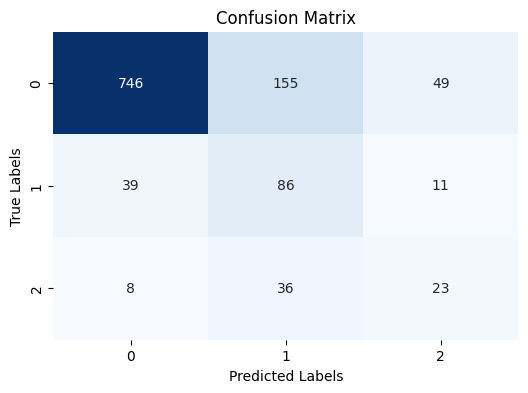


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 746/950 (78.53%)
Class 1: Correct Predictions / Total True Samples = 86/136 (63.24%)
Class 2: Correct Predictions / Total True Samples = 23/67 (34.33%)

Precision-Recall Curves:


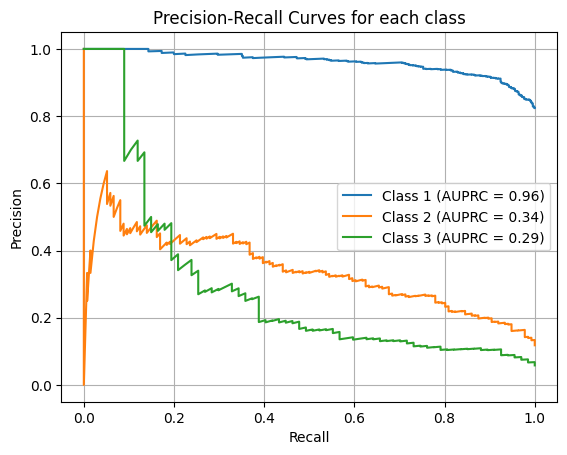


ROC Curves:


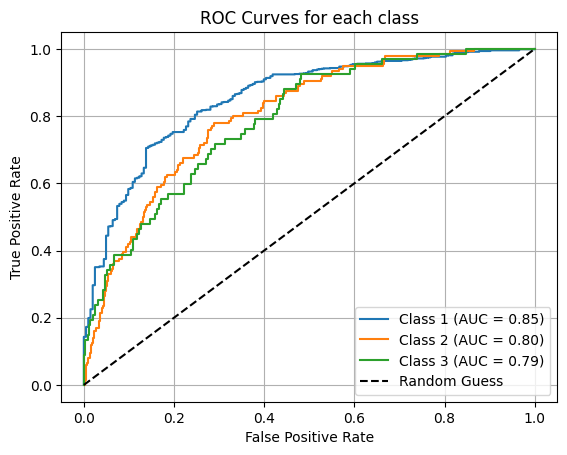


Mean F1 Score: 0.5264
Balanced Accuracy: 0.5870
Average AUPRC: 0.5289

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       950
           1       0.31      0.63      0.42       136
           2       0.28      0.34      0.31        67

    accuracy                           0.74      1153
   macro avg       0.51      0.59      0.53      1153
weighted avg       0.83      0.74      0.77      1153

Fold No: 2
Epoch [1/100], Loss: 1.0920, Accuracy: 0.3896
Validation Loss: 1.0921, Validation Accuracy: 0.4447
Epoch [2/100], Loss: 1.0754, Accuracy: 0.4466
Validation Loss: 1.0722, Validation Accuracy: 0.4898
Epoch [3/100], Loss: 1.0443, Accuracy: 0.5497
Validation Loss: 0.9849, Validation Accuracy: 0.4797
Epoch [4/100], Loss: 1.0134, Accuracy: 0.6082
Validation Loss: 0.9944, Validation Accuracy: 0.5535
Epoch [5/100], Loss: 0.9950, Accuracy: 0.6301
Validation Loss: 0.9640, Validation Accuracy: 0.5742
Epoch [6/100], Los

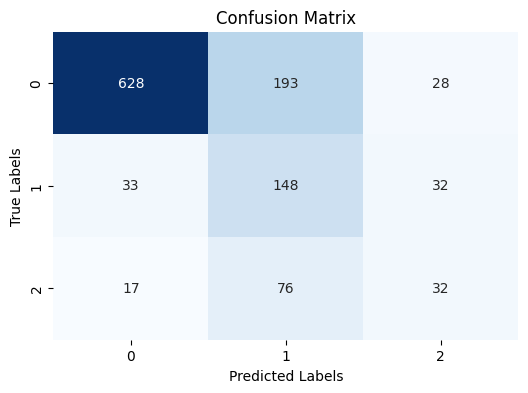


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 628/849 (73.97%)
Class 1: Correct Predictions / Total True Samples = 148/213 (69.48%)
Class 2: Correct Predictions / Total True Samples = 32/125 (25.60%)

Precision-Recall Curves:


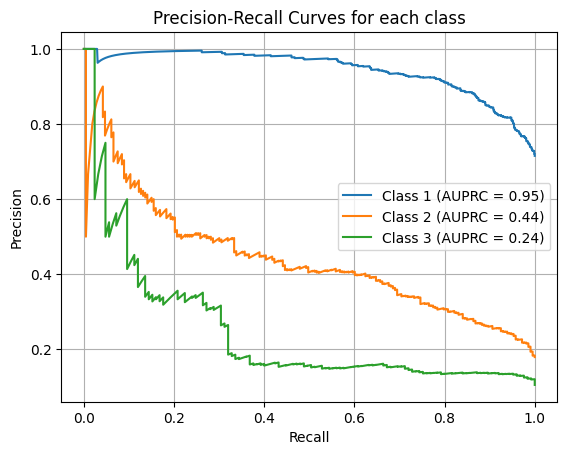


ROC Curves:


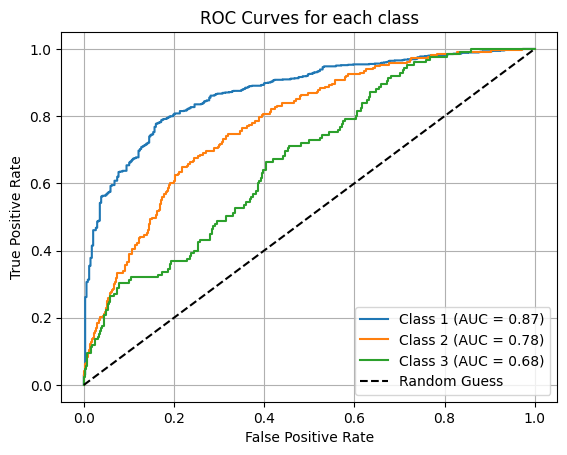


Mean F1 Score: 0.5291
Balanced Accuracy: 0.5635
Average AUPRC: 0.5430

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.74      0.82       849
           1       0.35      0.69      0.47       213
           2       0.35      0.26      0.29       125

    accuracy                           0.68      1187
   macro avg       0.54      0.56      0.53      1187
weighted avg       0.76      0.68      0.70      1187

Fold No: 3
Epoch [1/100], Loss: 1.0935, Accuracy: 0.3620
Validation Loss: 1.0963, Validation Accuracy: 0.3222
Epoch [2/100], Loss: 1.0813, Accuracy: 0.4489
Validation Loss: 1.1162, Validation Accuracy: 0.3379
Epoch [3/100], Loss: 1.0700, Accuracy: 0.4519
Validation Loss: 1.0740, Validation Accuracy: 0.4454
Epoch [4/100], Loss: 1.0487, Accuracy: 0.5481
Validation Loss: 1.0165, Validation Accuracy: 0.4442
Epoch [5/100], Loss: 1.0294, Accuracy: 0.5757
Validation Loss: 0.9920, Validation Accuracy: 0.4864
Epoch [6/100], Los

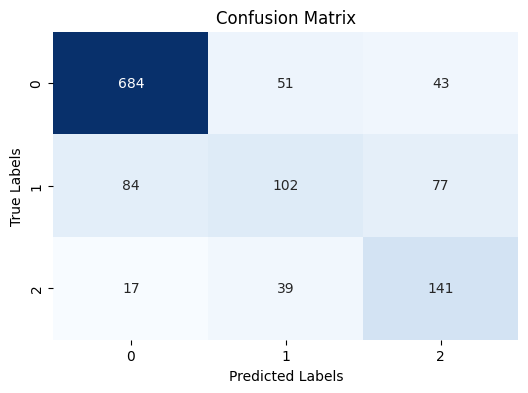


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 684/778 (87.92%)
Class 1: Correct Predictions / Total True Samples = 102/263 (38.78%)
Class 2: Correct Predictions / Total True Samples = 141/197 (71.57%)

Precision-Recall Curves:


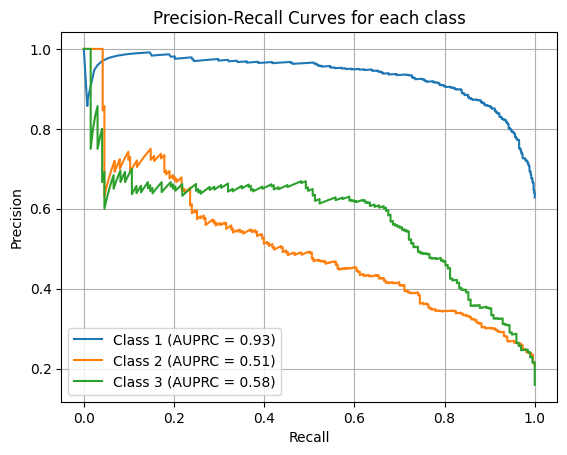


ROC Curves:


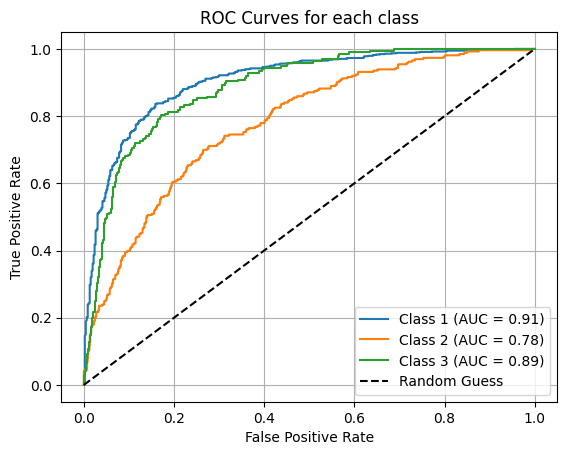


Mean F1 Score: 0.6464
Balanced Accuracy: 0.6609
Average AUPRC: 0.6721

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       778
           1       0.53      0.39      0.45       263
           2       0.54      0.72      0.62       197

    accuracy                           0.75      1238
   macro avg       0.65      0.66      0.65      1238
weighted avg       0.75      0.75      0.74      1238

Fold No: 4
Epoch [1/100], Loss: 1.0986, Accuracy: 0.3499
Validation Loss: 1.0972, Validation Accuracy: 0.3800
Epoch [2/100], Loss: 1.0933, Accuracy: 0.4226
Validation Loss: 1.0890, Validation Accuracy: 0.5076
Epoch [3/100], Loss: 1.0852, Accuracy: 0.4787
Validation Loss: 1.0787, Validation Accuracy: 0.5595
Epoch [4/100], Loss: 1.0749, Accuracy: 0.4953
Validation Loss: 1.0571, Validation Accuracy: 0.5684
Epoch [5/100], Loss: 1.0585, Accuracy: 0.5161
Validation Loss: 1.0133, Validation Accuracy: 0.5790
Epoch [6/100], Los

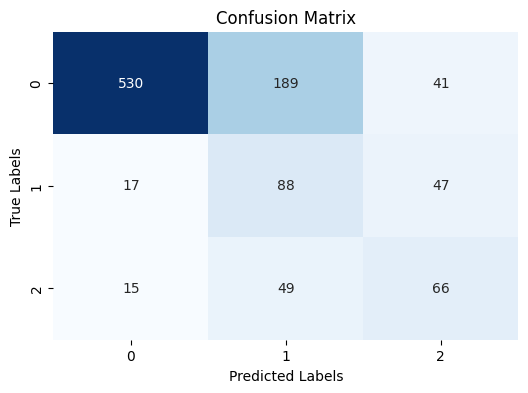


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 530/760 (69.74%)
Class 1: Correct Predictions / Total True Samples = 88/152 (57.89%)
Class 2: Correct Predictions / Total True Samples = 66/130 (50.77%)

Precision-Recall Curves:


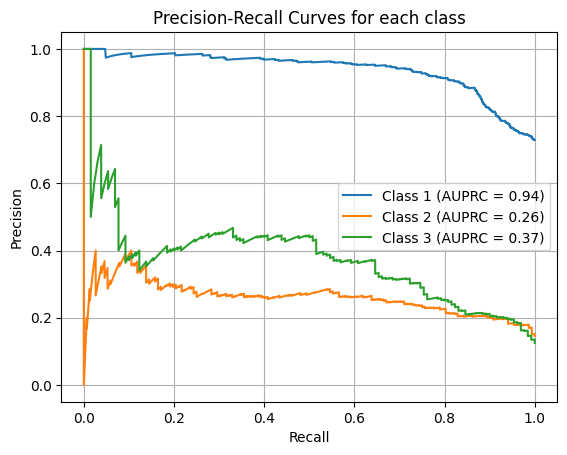


ROC Curves:


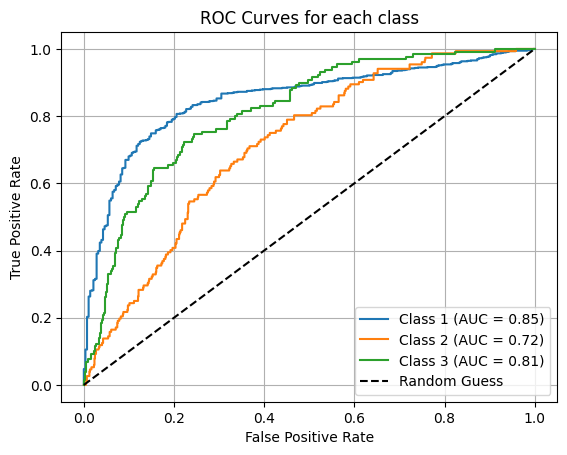


Mean F1 Score: 0.5449
Balanced Accuracy: 0.5947
Average AUPRC: 0.5237

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.70      0.80       760
           1       0.27      0.58      0.37       152
           2       0.43      0.51      0.46       130

    accuracy                           0.66      1042
   macro avg       0.55      0.59      0.54      1042
weighted avg       0.78      0.66      0.70      1042

Fold No: 5
Epoch [1/100], Loss: 1.0956, Accuracy: 0.3942
Validation Loss: 1.0954, Validation Accuracy: 0.4426
Epoch [2/100], Loss: 1.0848, Accuracy: 0.4670
Validation Loss: 1.0713, Validation Accuracy: 0.4788
Epoch [3/100], Loss: 1.0660, Accuracy: 0.5210
Validation Loss: 1.0393, Validation Accuracy: 0.5284
Epoch [4/100], Loss: 1.0453, Accuracy: 0.5330
Validation Loss: 0.9975, Validation Accuracy: 0.5366
Epoch [5/100], Loss: 1.0255, Accuracy: 0.5578
Validation Loss: 0.9700, Validation Accuracy: 0.5632
Epoch [6/100], Los

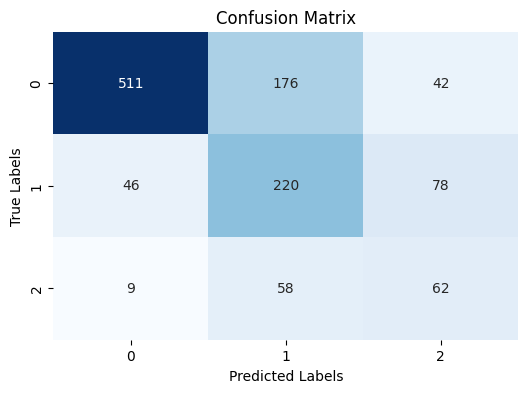


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 511/729 (70.10%)
Class 1: Correct Predictions / Total True Samples = 220/344 (63.95%)
Class 2: Correct Predictions / Total True Samples = 62/129 (48.06%)

Precision-Recall Curves:


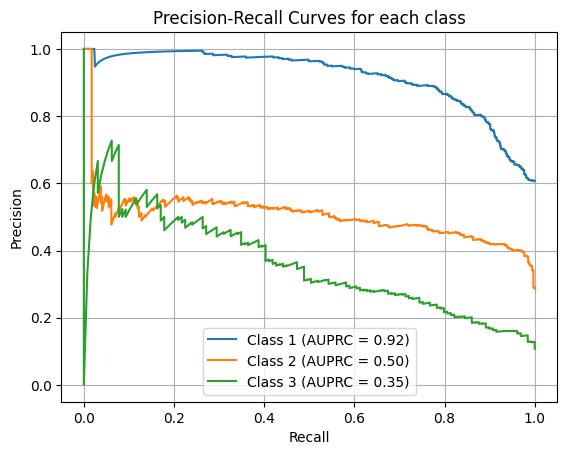


ROC Curves:


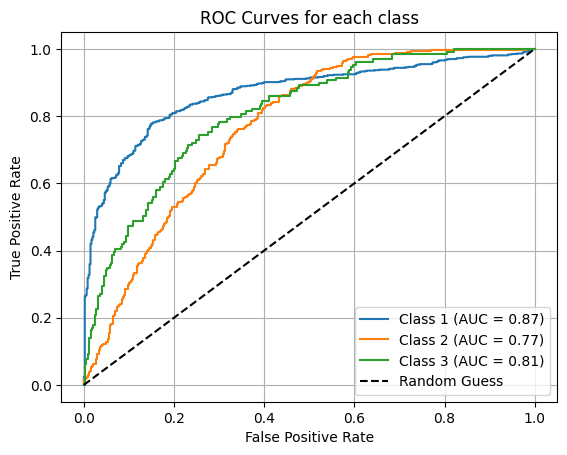


Mean F1 Score: 0.5798
Balanced Accuracy: 0.6070
Average AUPRC: 0.5922

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79       729
           1       0.48      0.64      0.55       344
           2       0.34      0.48      0.40       129

    accuracy                           0.66      1202
   macro avg       0.58      0.61      0.58      1202
weighted avg       0.72      0.66      0.68      1202


RESULTS FOR PARAMETER SET 1
Accuracy for each fold: ['0.5870', '0.5635', '0.6609', '0.5947', '0.6070']
Average Accuracy: 0.6026
AUPRC for each fold: ['0.5289', '0.5430', '0.6721', '0.5237', '0.5922']
Average AUPRC: 0.5720
Best fold class-wise balanced accuracy: ['0.8792', '0.6948', '0.7157']


RUNNING PARAMETER SET 2/5
Parameters: {'hidden_size': 1024, 'num_layers': 1, 'dropout': 0.1, 'learning_rate': 3.1698115236603614e-06, 'weight_decay': 4.8990822406347735e-06, 'batch_size': 10}

Fold No: 1
Epoch [1/100], Loss: 1.0

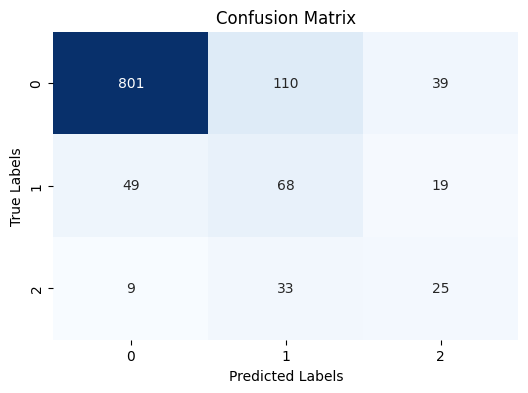


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 801/950 (84.32%)
Class 1: Correct Predictions / Total True Samples = 68/136 (50.00%)
Class 2: Correct Predictions / Total True Samples = 25/67 (37.31%)

Precision-Recall Curves:


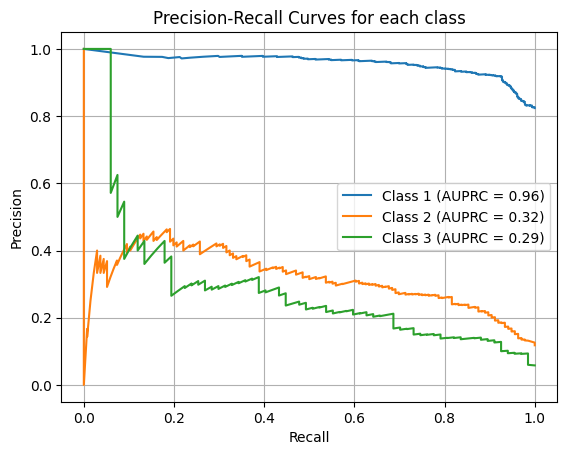


ROC Curves:


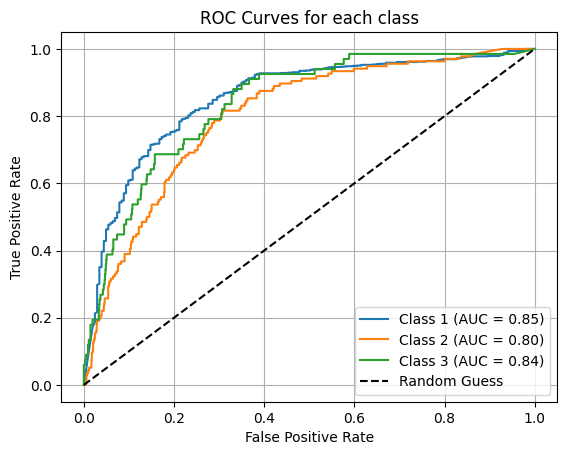


Mean F1 Score: 0.5369
Balanced Accuracy: 0.5721
Average AUPRC: 0.5204

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.89       950
           1       0.32      0.50      0.39       136
           2       0.30      0.37      0.33        67

    accuracy                           0.78      1153
   macro avg       0.52      0.57      0.54      1153
weighted avg       0.82      0.78      0.80      1153

Fold No: 2
Epoch [1/100], Loss: 1.0917, Accuracy: 0.4050
Validation Loss: 1.1005, Validation Accuracy: 0.4610
Epoch [2/100], Loss: 1.0733, Accuracy: 0.4656
Validation Loss: 1.0585, Validation Accuracy: 0.5006
Epoch [3/100], Loss: 1.0461, Accuracy: 0.5607
Validation Loss: 1.0132, Validation Accuracy: 0.5155
Epoch [4/100], Loss: 1.0117, Accuracy: 0.6213
Validation Loss: 0.9712, Validation Accuracy: 0.5297
Epoch [5/100], Loss: 0.9971, Accuracy: 0.6352
Validation Loss: 0.9938, Validation Accuracy: 0.5461
Epoch [6/100], Los

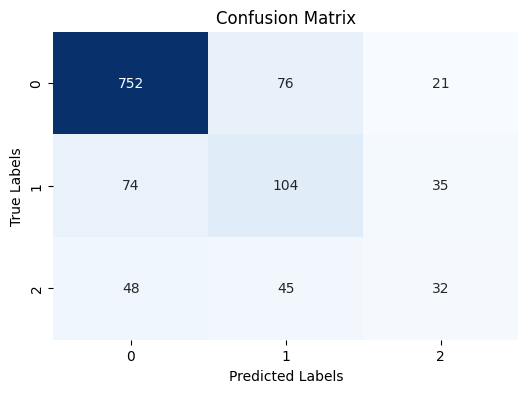


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 752/849 (88.57%)
Class 1: Correct Predictions / Total True Samples = 104/213 (48.83%)
Class 2: Correct Predictions / Total True Samples = 32/125 (25.60%)

Precision-Recall Curves:


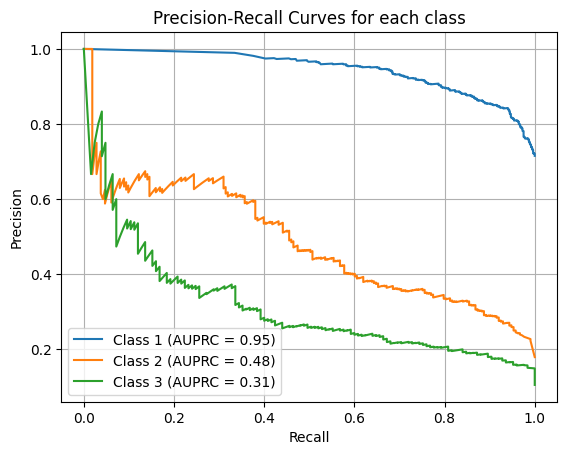


ROC Curves:


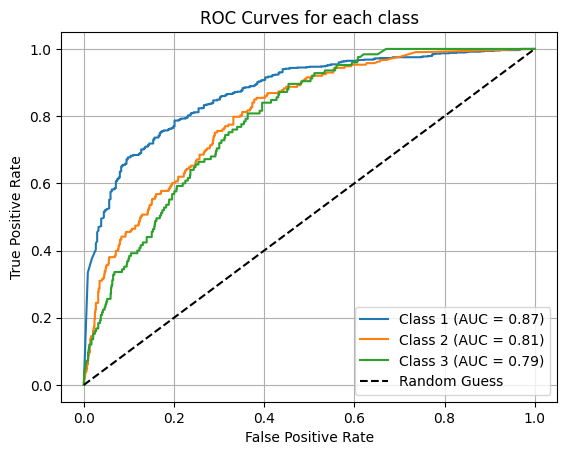


Mean F1 Score: 0.5494
Balanced Accuracy: 0.5433
Average AUPRC: 0.5803

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       849
           1       0.46      0.49      0.47       213
           2       0.36      0.26      0.30       125

    accuracy                           0.75      1187
   macro avg       0.56      0.54      0.55      1187
weighted avg       0.74      0.75      0.74      1187

Fold No: 3
Epoch [1/100], Loss: 1.0943, Accuracy: 0.3753
Validation Loss: 1.1020, Validation Accuracy: 0.3411
Epoch [2/100], Loss: 1.0833, Accuracy: 0.4509
Validation Loss: 1.0975, Validation Accuracy: 0.3785
Epoch [3/100], Loss: 1.0686, Accuracy: 0.4622
Validation Loss: 1.0821, Validation Accuracy: 0.3769
Epoch [4/100], Loss: 1.0540, Accuracy: 0.5133
Validation Loss: 1.0762, Validation Accuracy: 0.4197
Epoch [5/100], Loss: 1.0330, Accuracy: 0.5634
Validation Loss: 1.0255, Validation Accuracy: 0.4652
Epoch [6/100], Los

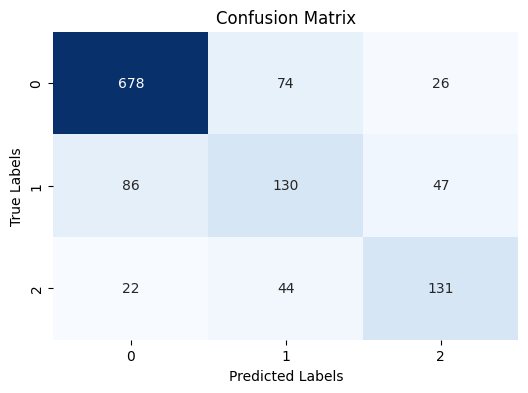


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 678/778 (87.15%)
Class 1: Correct Predictions / Total True Samples = 130/263 (49.43%)
Class 2: Correct Predictions / Total True Samples = 131/197 (66.50%)

Precision-Recall Curves:


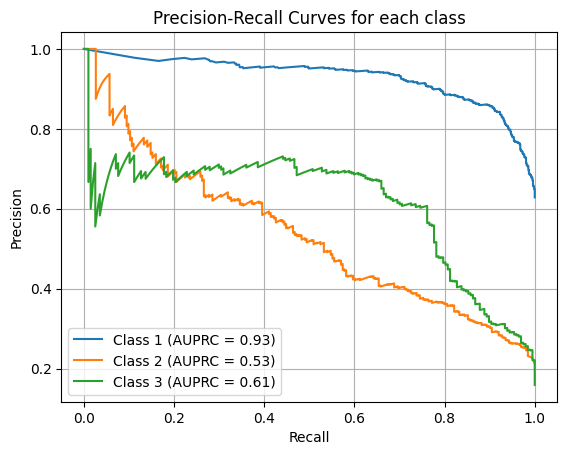


ROC Curves:


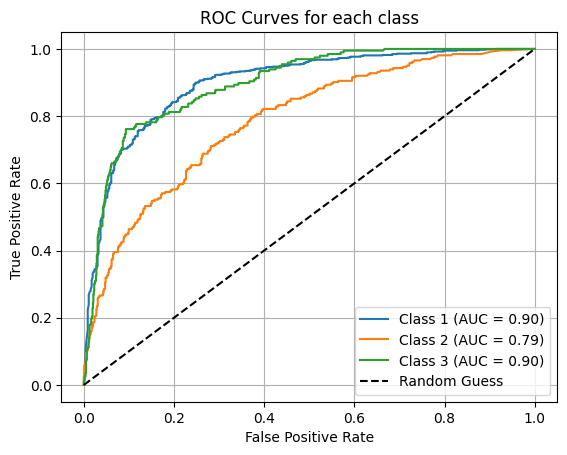


Mean F1 Score: 0.6764
Balanced Accuracy: 0.6769
Average AUPRC: 0.6922

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       778
           1       0.52      0.49      0.51       263
           2       0.64      0.66      0.65       197

    accuracy                           0.76      1238
   macro avg       0.68      0.68      0.68      1238
weighted avg       0.76      0.76      0.76      1238

Fold No: 4
Epoch [1/100], Loss: 1.0974, Accuracy: 0.3614
Validation Loss: 1.0899, Validation Accuracy: 0.5080
Epoch [2/100], Loss: 1.0901, Accuracy: 0.4517
Validation Loss: 1.0814, Validation Accuracy: 0.5447
Epoch [3/100], Loss: 1.0843, Accuracy: 0.4777
Validation Loss: 1.0748, Validation Accuracy: 0.5652
Epoch [4/100], Loss: 1.0726, Accuracy: 0.5057
Validation Loss: 1.0536, Validation Accuracy: 0.6031
Epoch [5/100], Loss: 1.0594, Accuracy: 0.5026
Validation Loss: 1.0513, Validation Accuracy: 0.5612
Epoch [6/100], Los

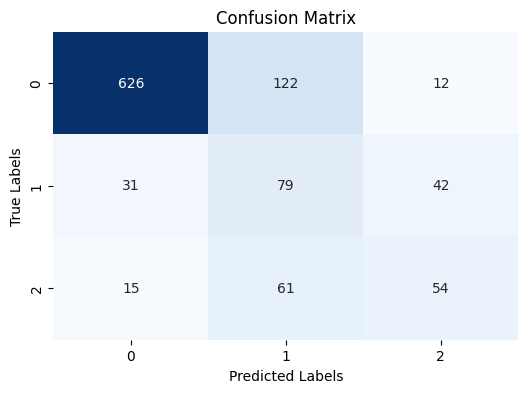


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 626/760 (82.37%)
Class 1: Correct Predictions / Total True Samples = 79/152 (51.97%)
Class 2: Correct Predictions / Total True Samples = 54/130 (41.54%)

Precision-Recall Curves:


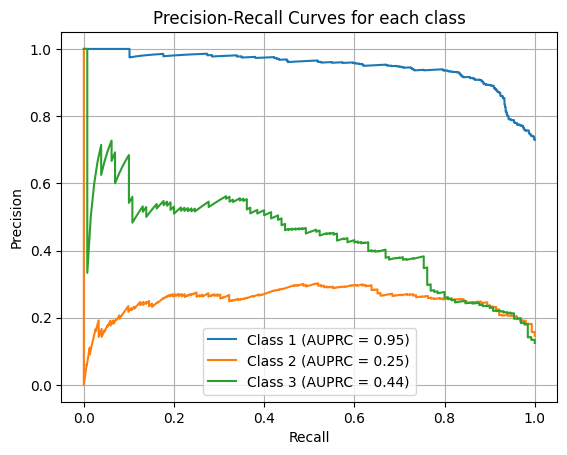


ROC Curves:


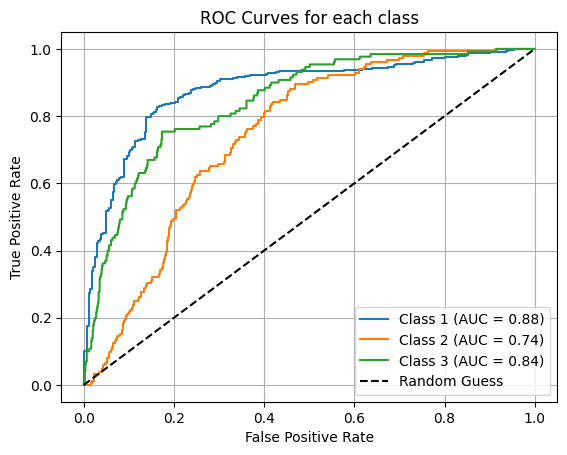


Mean F1 Score: 0.5699
Balanced Accuracy: 0.5863
Average AUPRC: 0.5452

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       760
           1       0.30      0.52      0.38       152
           2       0.50      0.42      0.45       130

    accuracy                           0.73      1042
   macro avg       0.58      0.59      0.57      1042
weighted avg       0.79      0.73      0.75      1042

Fold No: 5
Epoch [1/100], Loss: 1.0943, Accuracy: 0.3942
Validation Loss: 1.0767, Validation Accuracy: 0.4808
Epoch [2/100], Loss: 1.0795, Accuracy: 0.4987
Validation Loss: 1.0522, Validation Accuracy: 0.5028
Epoch [3/100], Loss: 1.0579, Accuracy: 0.5244
Validation Loss: 1.0121, Validation Accuracy: 0.5146
Epoch [4/100], Loss: 1.0297, Accuracy: 0.5656
Validation Loss: 0.9976, Validation Accuracy: 0.5419
Epoch [5/100], Loss: 1.0166, Accuracy: 0.5870
Validation Loss: 1.0140, Validation Accuracy: 0.5450
Epoch [6/100], Los

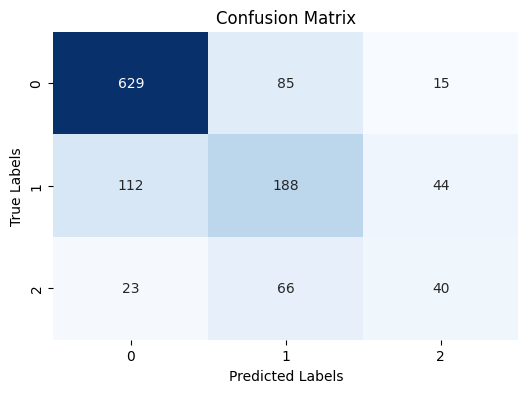


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 629/729 (86.28%)
Class 1: Correct Predictions / Total True Samples = 188/344 (54.65%)
Class 2: Correct Predictions / Total True Samples = 40/129 (31.01%)

Precision-Recall Curves:


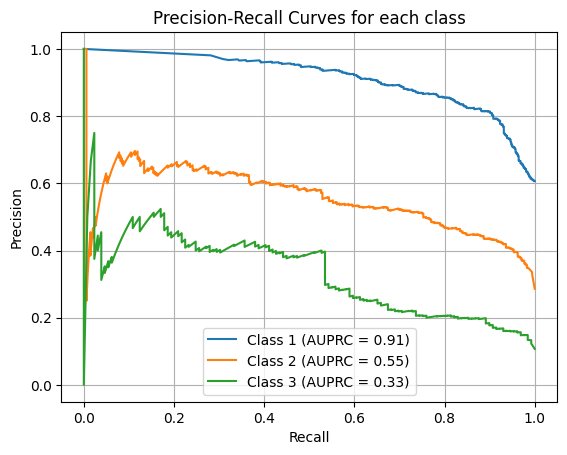


ROC Curves:


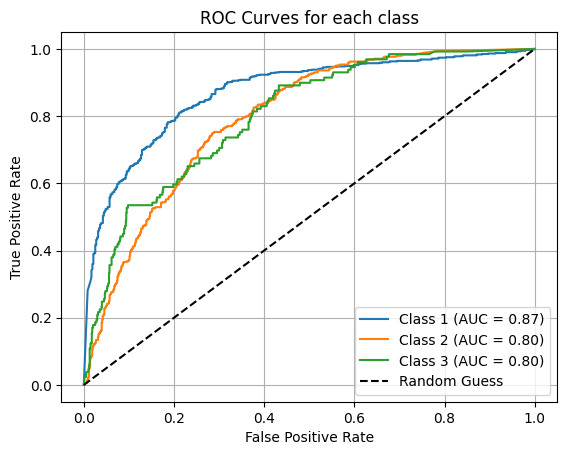


Mean F1 Score: 0.5813
Balanced Accuracy: 0.5731
Average AUPRC: 0.5982

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       729
           1       0.55      0.55      0.55       344
           2       0.40      0.31      0.35       129

    accuracy                           0.71      1202
   macro avg       0.59      0.57      0.58      1202
weighted avg       0.70      0.71      0.71      1202


RESULTS FOR PARAMETER SET 2
Accuracy for each fold: ['0.5721', '0.5433', '0.6769', '0.5863', '0.5731']
Average Accuracy: 0.5904
AUPRC for each fold: ['0.5204', '0.5803', '0.6922', '0.5452', '0.5982']
Average AUPRC: 0.5872
Best fold class-wise balanced accuracy: ['0.8857', '0.5465', '0.6650']


RUNNING PARAMETER SET 3/5
Parameters: {'hidden_size': 1024, 'num_layers': 1, 'dropout': 0.30000000000000004, 'learning_rate': 4.041251088887564e-06, 'weight_decay': 5.788250075003372e-06, 'batch_size': 10}

Fold No: 1
Epoch [1/1

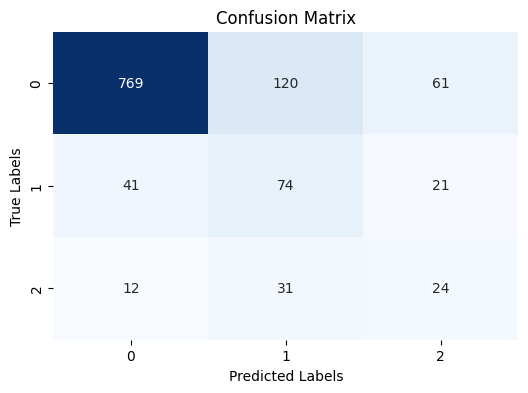


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 769/950 (80.95%)
Class 1: Correct Predictions / Total True Samples = 74/136 (54.41%)
Class 2: Correct Predictions / Total True Samples = 24/67 (35.82%)

Precision-Recall Curves:


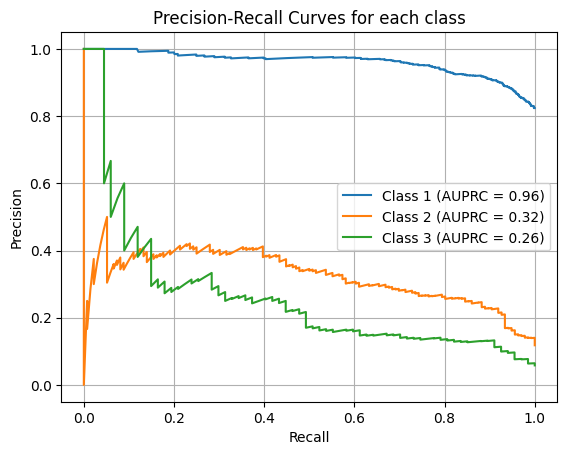


ROC Curves:


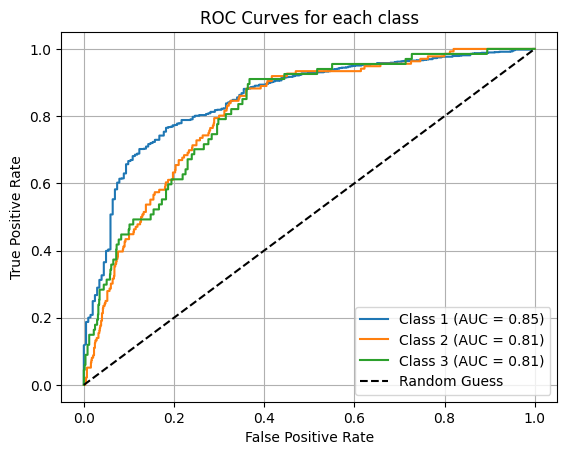


Mean F1 Score: 0.5185
Balanced Accuracy: 0.5706
Average AUPRC: 0.5134

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       950
           1       0.33      0.54      0.41       136
           2       0.23      0.36      0.28        67

    accuracy                           0.75      1153
   macro avg       0.50      0.57      0.52      1153
weighted avg       0.82      0.75      0.78      1153

Fold No: 2
Epoch [1/100], Loss: 1.0904, Accuracy: 0.4072
Validation Loss: 1.0798, Validation Accuracy: 0.4710
Epoch [2/100], Loss: 1.0645, Accuracy: 0.5000
Validation Loss: 1.0840, Validation Accuracy: 0.5103
Epoch [3/100], Loss: 1.0296, Accuracy: 0.5716
Validation Loss: 0.9578, Validation Accuracy: 0.5022
Epoch [4/100], Loss: 1.0004, Accuracy: 0.6265
Validation Loss: 0.9718, Validation Accuracy: 0.5346
Epoch [5/100], Loss: 0.9842, Accuracy: 0.6667
Validation Loss: 0.9944, Validation Accuracy: 0.5681
Epoch [6/100], Los

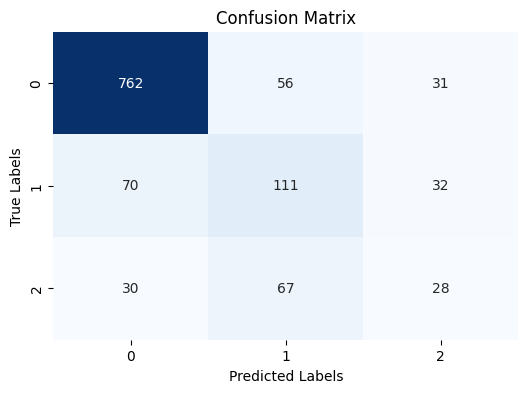


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 762/849 (89.75%)
Class 1: Correct Predictions / Total True Samples = 111/213 (52.11%)
Class 2: Correct Predictions / Total True Samples = 28/125 (22.40%)

Precision-Recall Curves:


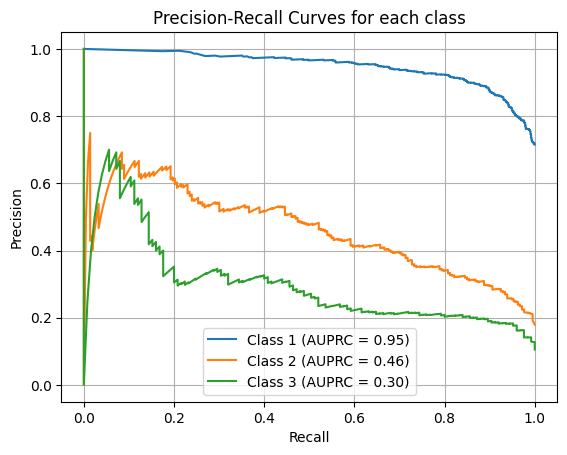


ROC Curves:


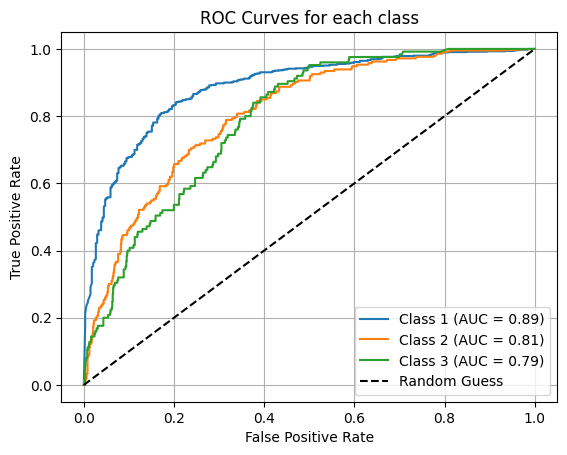


Mean F1 Score: 0.5489
Balanced Accuracy: 0.5476
Average AUPRC: 0.5677

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       849
           1       0.47      0.52      0.50       213
           2       0.31      0.22      0.26       125

    accuracy                           0.76      1187
   macro avg       0.56      0.55      0.55      1187
weighted avg       0.75      0.76      0.75      1187

Fold No: 3
Epoch [1/100], Loss: 1.0935, Accuracy: 0.3875
Validation Loss: 1.1036, Validation Accuracy: 0.3617
Epoch [2/100], Loss: 1.0812, Accuracy: 0.4274
Validation Loss: 1.1255, Validation Accuracy: 0.3424
Epoch [3/100], Loss: 1.0684, Accuracy: 0.4632
Validation Loss: 1.0812, Validation Accuracy: 0.3795
Epoch [4/100], Loss: 1.0544, Accuracy: 0.5133
Validation Loss: 1.0282, Validation Accuracy: 0.4192
Epoch [5/100], Loss: 1.0318, Accuracy: 0.5511
Validation Loss: 1.0256, Validation Accuracy: 0.4576
Epoch [6/100], Los

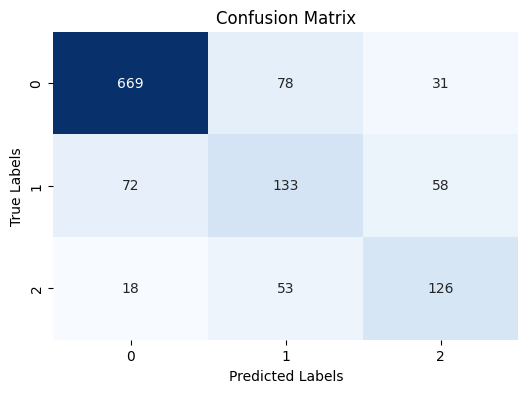


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 669/778 (85.99%)
Class 1: Correct Predictions / Total True Samples = 133/263 (50.57%)
Class 2: Correct Predictions / Total True Samples = 126/197 (63.96%)

Precision-Recall Curves:


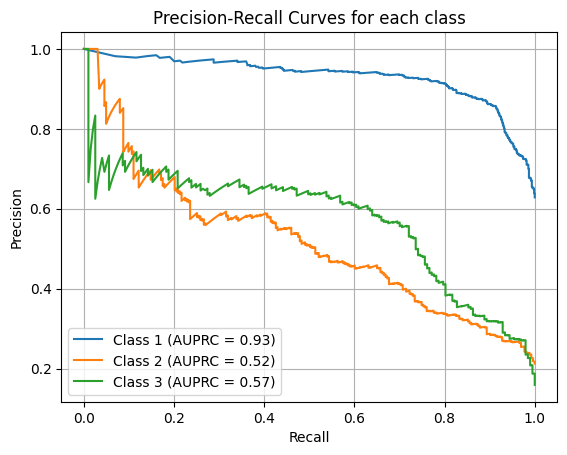


ROC Curves:


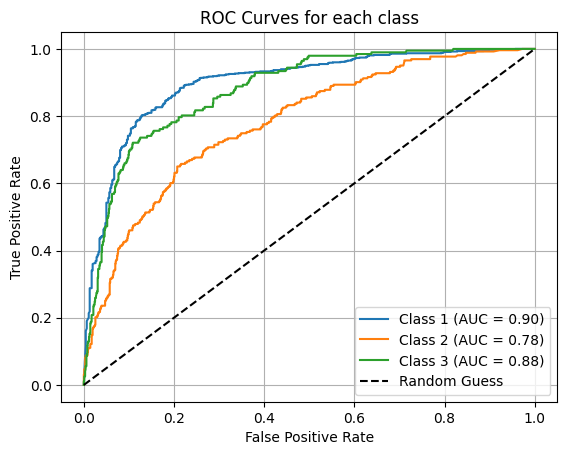


Mean F1 Score: 0.6623
Balanced Accuracy: 0.6684
Average AUPRC: 0.6732

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       778
           1       0.50      0.51      0.50       263
           2       0.59      0.64      0.61       197

    accuracy                           0.75      1238
   macro avg       0.66      0.67      0.66      1238
weighted avg       0.75      0.75      0.75      1238

Fold No: 4
Epoch [1/100], Loss: 1.0973, Accuracy: 0.3624
Validation Loss: 1.0741, Validation Accuracy: 0.4175
Epoch [2/100], Loss: 1.0913, Accuracy: 0.3821
Validation Loss: 1.0690, Validation Accuracy: 0.4721
Epoch [3/100], Loss: 1.0835, Accuracy: 0.4476
Validation Loss: 1.0723, Validation Accuracy: 0.5446
Epoch [4/100], Loss: 1.0730, Accuracy: 0.4891
Validation Loss: 1.0546, Validation Accuracy: 0.5561
Epoch [5/100], Loss: 1.0595, Accuracy: 0.4964
Validation Loss: 1.0366, Validation Accuracy: 0.5858
Epoch [6/100], Los

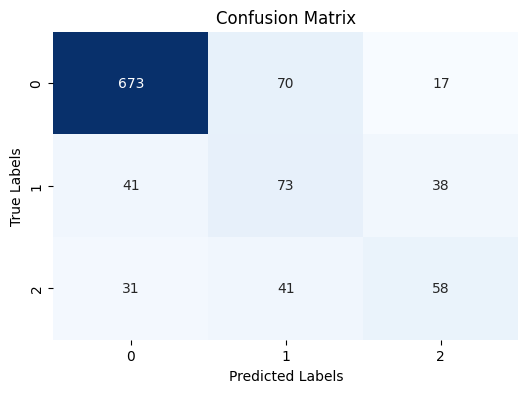


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 673/760 (88.55%)
Class 1: Correct Predictions / Total True Samples = 73/152 (48.03%)
Class 2: Correct Predictions / Total True Samples = 58/130 (44.62%)

Precision-Recall Curves:


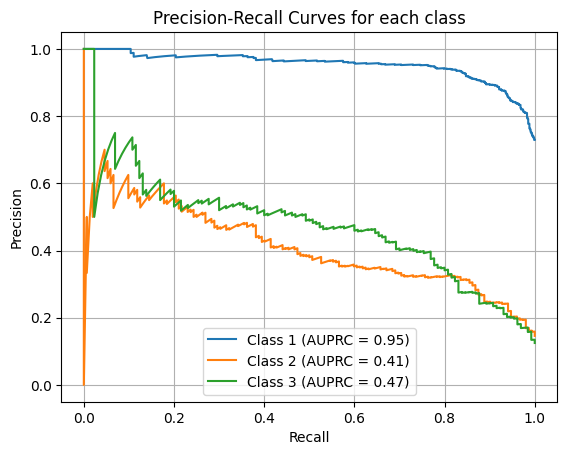


ROC Curves:


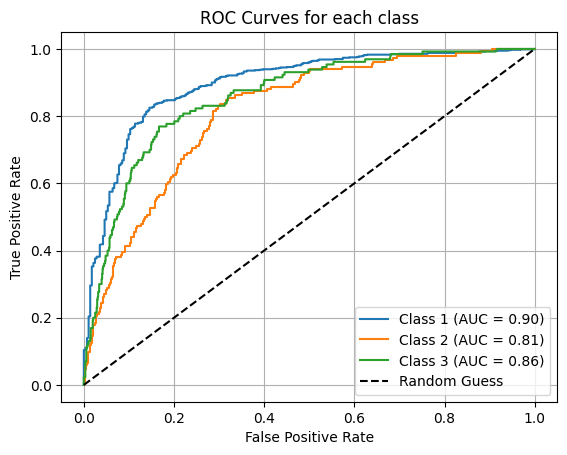


Mean F1 Score: 0.6021
Balanced Accuracy: 0.6040
Average AUPRC: 0.6098

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       760
           1       0.40      0.48      0.43       152
           2       0.51      0.45      0.48       130

    accuracy                           0.77      1042
   macro avg       0.60      0.60      0.60      1042
weighted avg       0.78      0.77      0.78      1042

Fold No: 5
Epoch [1/100], Loss: 1.0971, Accuracy: 0.3625
Validation Loss: 1.1071, Validation Accuracy: 0.3598
Epoch [2/100], Loss: 1.0855, Accuracy: 0.4516
Validation Loss: 1.0814, Validation Accuracy: 0.4850
Epoch [3/100], Loss: 1.0624, Accuracy: 0.5167
Validation Loss: 1.0349, Validation Accuracy: 0.5161
Epoch [4/100], Loss: 1.0347, Accuracy: 0.5476
Validation Loss: 0.9913, Validation Accuracy: 0.5475
Epoch [5/100], Loss: 1.0184, Accuracy: 0.5861
Validation Loss: 0.9724, Validation Accuracy: 0.5687
Epoch [6/100], Los

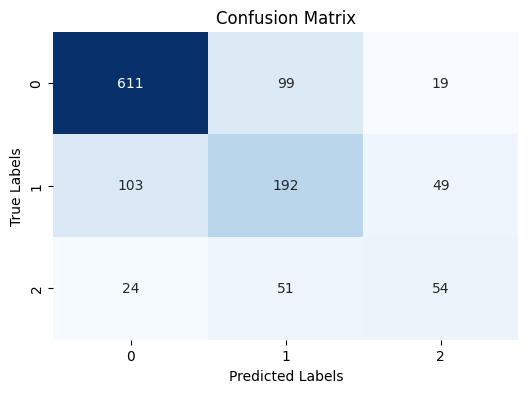


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 611/729 (83.81%)
Class 1: Correct Predictions / Total True Samples = 192/344 (55.81%)
Class 2: Correct Predictions / Total True Samples = 54/129 (41.86%)

Precision-Recall Curves:


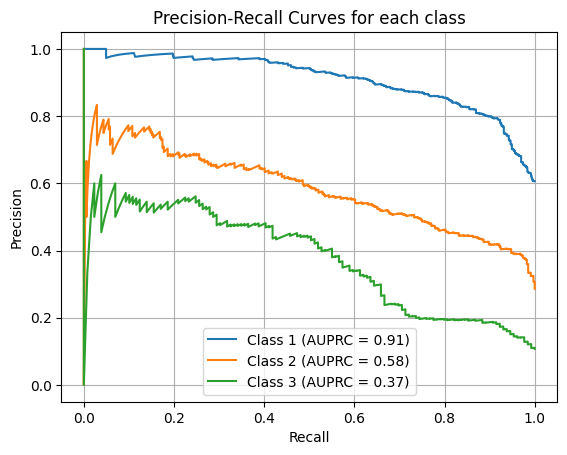


ROC Curves:


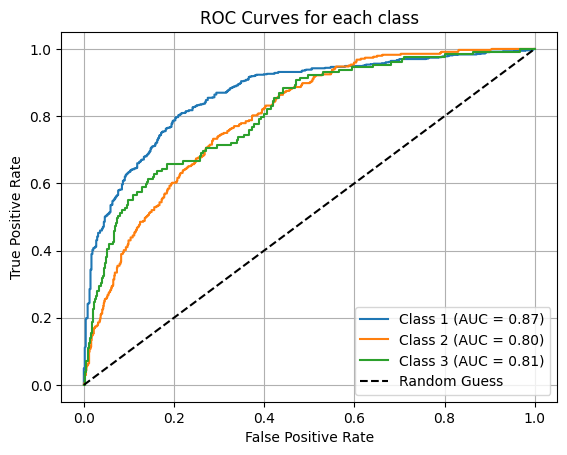


Mean F1 Score: 0.6077
Balanced Accuracy: 0.6050
Average AUPRC: 0.6210

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       729
           1       0.56      0.56      0.56       344
           2       0.44      0.42      0.43       129

    accuracy                           0.71      1202
   macro avg       0.61      0.60      0.61      1202
weighted avg       0.71      0.71      0.71      1202


RESULTS FOR PARAMETER SET 3
Accuracy for each fold: ['0.5706', '0.5476', '0.6684', '0.6040', '0.6050']
Average Accuracy: 0.5991
AUPRC for each fold: ['0.5134', '0.5677', '0.6732', '0.6098', '0.6210']
Average AUPRC: 0.5970
Best fold class-wise balanced accuracy: ['0.8975', '0.5581', '0.6396']


RUNNING PARAMETER SET 4/5
Parameters: {'hidden_size': 1024, 'num_layers': 1, 'dropout': 0.30000000000000004, 'learning_rate': 2.553105885330496e-05, 'weight_decay': 7.720918959587612e-06, 'batch_size': 10}

Fold No: 1
Epoch [1/1

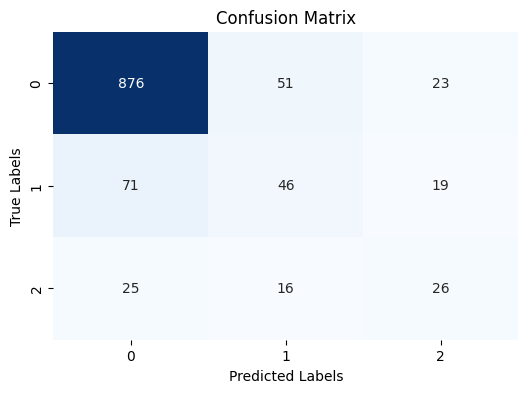


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 876/950 (92.21%)
Class 1: Correct Predictions / Total True Samples = 46/136 (33.82%)
Class 2: Correct Predictions / Total True Samples = 26/67 (38.81%)

Precision-Recall Curves:


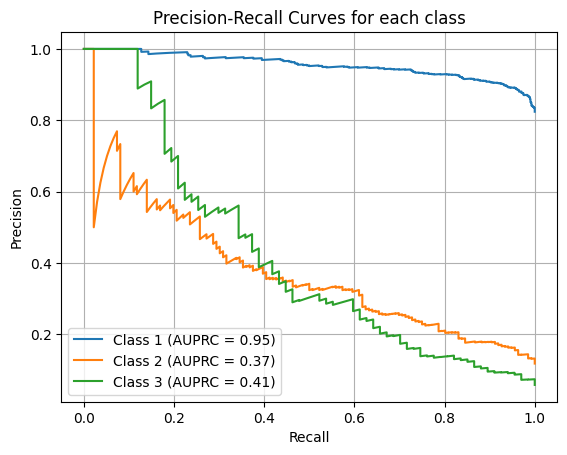


ROC Curves:


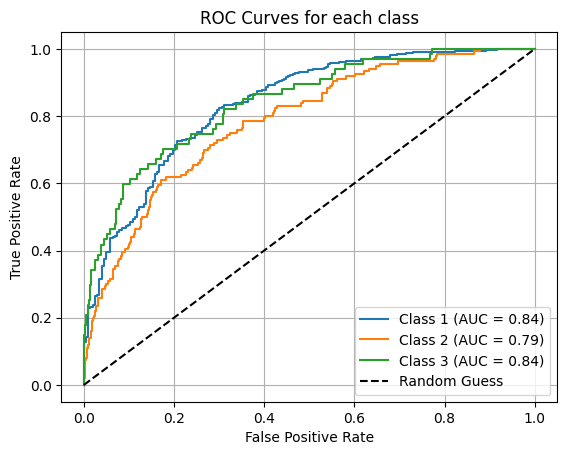


Mean F1 Score: 0.5554
Balanced Accuracy: 0.5495
Average AUPRC: 0.5814

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       950
           1       0.41      0.34      0.37       136
           2       0.38      0.39      0.39        67

    accuracy                           0.82      1153
   macro avg       0.56      0.55      0.56      1153
weighted avg       0.81      0.82      0.82      1153

Fold No: 2
Epoch [1/100], Loss: 1.0574, Accuracy: 0.4744
Validation Loss: 0.9312, Validation Accuracy: 0.5456
Epoch [2/100], Loss: 0.9973, Accuracy: 0.6111
Validation Loss: 0.9376, Validation Accuracy: 0.5595
Epoch [3/100], Loss: 0.9802, Accuracy: 0.6455
Validation Loss: 0.8660, Validation Accuracy: 0.4962
Epoch [4/100], Loss: 0.9806, Accuracy: 0.6367
Validation Loss: 0.9113, Validation Accuracy: 0.5672
Epoch [5/100], Loss: 0.9696, Accuracy: 0.6601
Validation Loss: 0.9217, Validation Accuracy: 0.5772
Epoch [6/100], Los

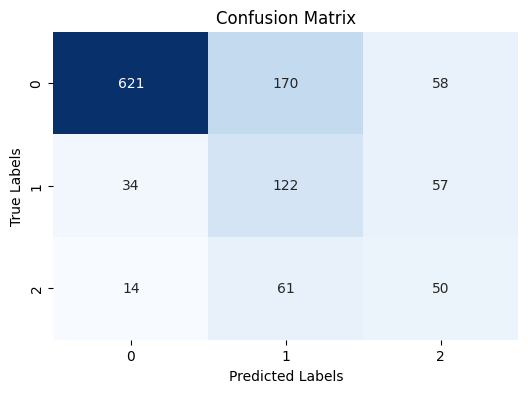


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 621/849 (73.14%)
Class 1: Correct Predictions / Total True Samples = 122/213 (57.28%)
Class 2: Correct Predictions / Total True Samples = 50/125 (40.00%)

Precision-Recall Curves:


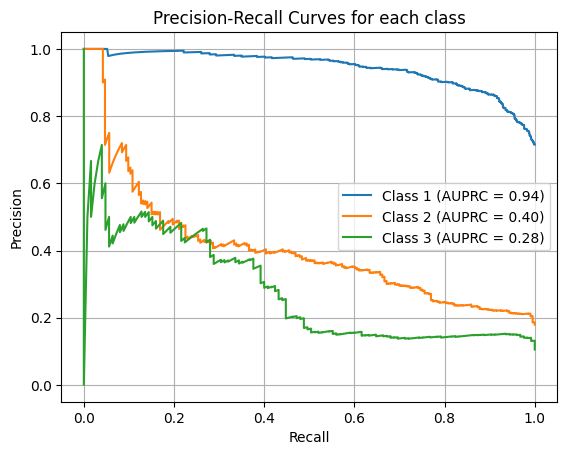


ROC Curves:


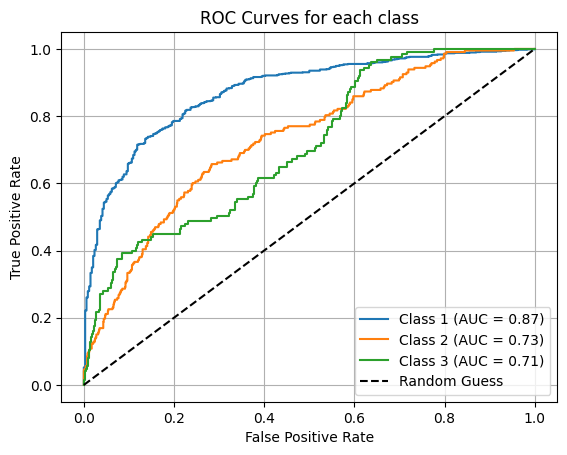


Mean F1 Score: 0.5314
Balanced Accuracy: 0.5681
Average AUPRC: 0.5404

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.73      0.82       849
           1       0.35      0.57      0.43       213
           2       0.30      0.40      0.34       125

    accuracy                           0.67      1187
   macro avg       0.53      0.57      0.53      1187
weighted avg       0.76      0.67      0.70      1187

Fold No: 3
Epoch [1/100], Loss: 1.0846, Accuracy: 0.4059
Validation Loss: 1.0541, Validation Accuracy: 0.4371
Epoch [2/100], Loss: 1.0257, Accuracy: 0.5429
Validation Loss: 0.9863, Validation Accuracy: 0.5164
Epoch [3/100], Loss: 1.0107, Accuracy: 0.5849
Validation Loss: 0.9425, Validation Accuracy: 0.4502
Epoch [4/100], Loss: 1.0044, Accuracy: 0.5910
Validation Loss: 0.9549, Validation Accuracy: 0.5219
Epoch [5/100], Loss: 0.9814, Accuracy: 0.6329
Validation Loss: 0.9439, Validation Accuracy: 0.5259
Epoch [6/100], Los

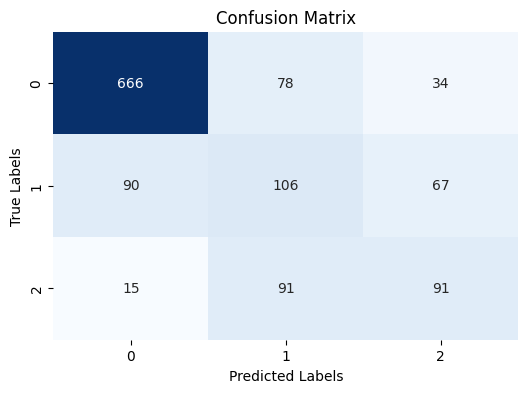


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 666/778 (85.60%)
Class 1: Correct Predictions / Total True Samples = 106/263 (40.30%)
Class 2: Correct Predictions / Total True Samples = 91/197 (46.19%)

Precision-Recall Curves:


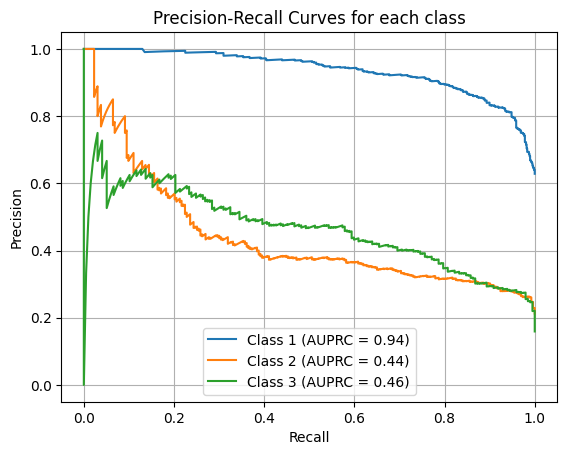


ROC Curves:


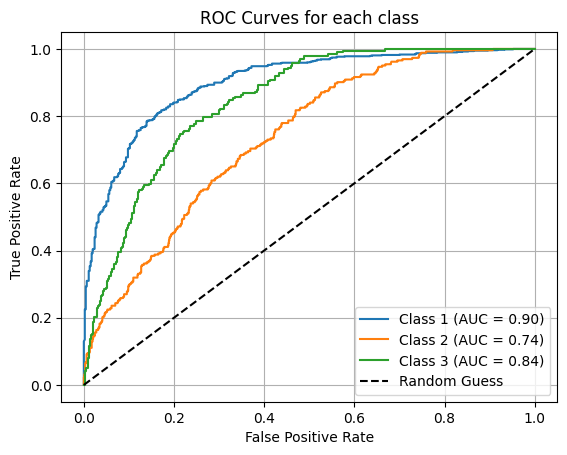


Mean F1 Score: 0.5739
Balanced Accuracy: 0.5737
Average AUPRC: 0.6117

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       778
           1       0.39      0.40      0.39       263
           2       0.47      0.46      0.47       197

    accuracy                           0.70      1238
   macro avg       0.57      0.57      0.57      1238
weighted avg       0.70      0.70      0.70      1238

Fold No: 4
Epoch [1/100], Loss: 1.0945, Accuracy: 0.3894
Validation Loss: 1.0979, Validation Accuracy: 0.4175
Epoch [2/100], Loss: 1.0491, Accuracy: 0.5109
Validation Loss: 0.9660, Validation Accuracy: 0.5898
Epoch [3/100], Loss: 1.0270, Accuracy: 0.5462
Validation Loss: 0.9306, Validation Accuracy: 0.5715
Epoch [4/100], Loss: 1.0133, Accuracy: 0.5846
Validation Loss: 1.0550, Validation Accuracy: 0.5521
Epoch [5/100], Loss: 0.9947, Accuracy: 0.6241
Validation Loss: 1.0116, Validation Accuracy: 0.5861
Epoch [6/100], Los

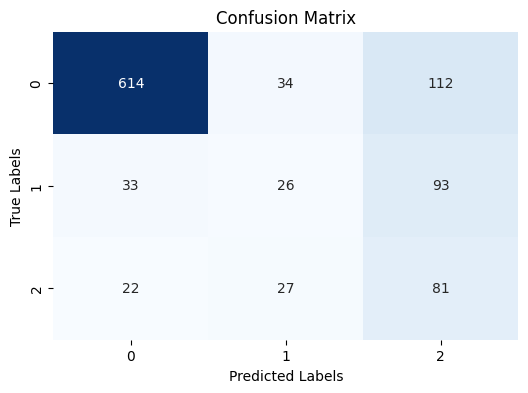


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 614/760 (80.79%)
Class 1: Correct Predictions / Total True Samples = 26/152 (17.11%)
Class 2: Correct Predictions / Total True Samples = 81/130 (62.31%)

Precision-Recall Curves:


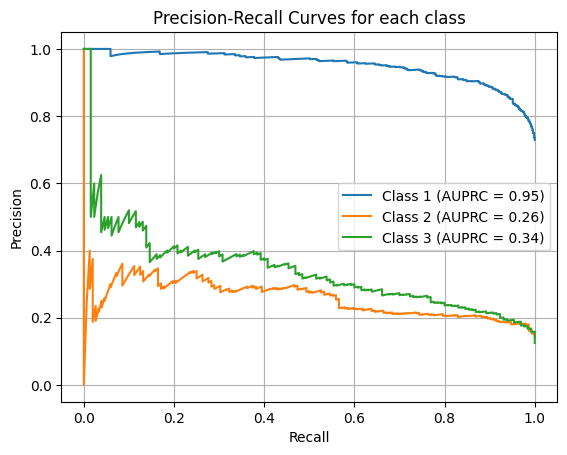


ROC Curves:


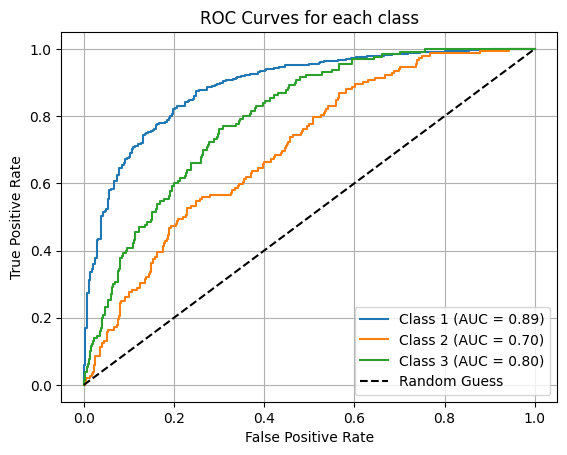


Mean F1 Score: 0.4888
Balanced Accuracy: 0.5340
Average AUPRC: 0.5157

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       760
           1       0.30      0.17      0.22       152
           2       0.28      0.62      0.39       130

    accuracy                           0.69      1042
   macro avg       0.50      0.53      0.49      1042
weighted avg       0.75      0.69      0.71      1042

Fold No: 5
Epoch [1/100], Loss: 1.0726, Accuracy: 0.4567
Validation Loss: 1.0148, Validation Accuracy: 0.5472
Epoch [2/100], Loss: 1.0254, Accuracy: 0.5536
Validation Loss: 1.0620, Validation Accuracy: 0.4851
Epoch [3/100], Loss: 1.0136, Accuracy: 0.5835
Validation Loss: 1.0719, Validation Accuracy: 0.4818
Epoch [4/100], Loss: 0.9923, Accuracy: 0.6221
Validation Loss: 0.9228, Validation Accuracy: 0.6013
Epoch [5/100], Loss: 0.9992, Accuracy: 0.6058
Validation Loss: 0.9155, Validation Accuracy: 0.5421
Epoch [6/100], Los

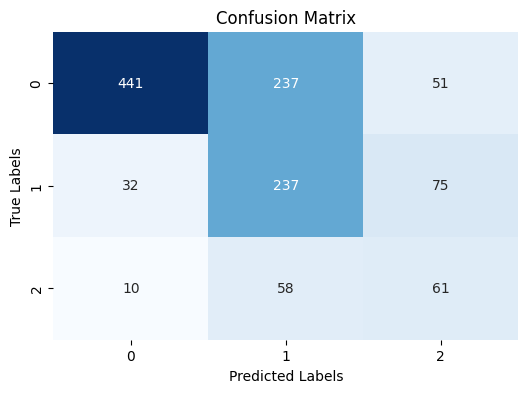


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 441/729 (60.49%)
Class 1: Correct Predictions / Total True Samples = 237/344 (68.90%)
Class 2: Correct Predictions / Total True Samples = 61/129 (47.29%)

Precision-Recall Curves:


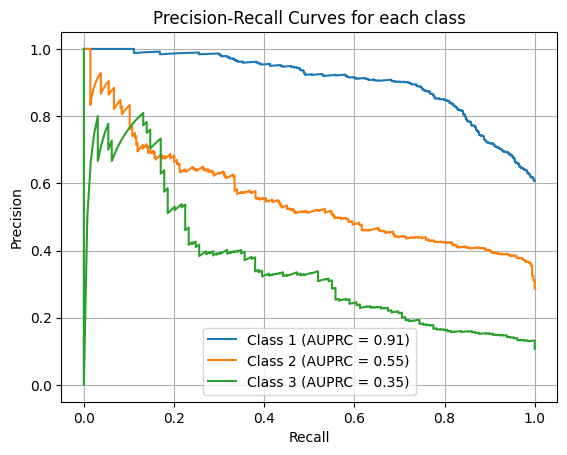


ROC Curves:


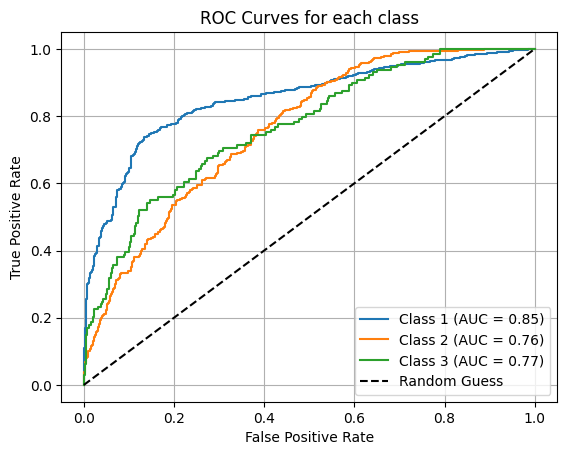


Mean F1 Score: 0.5516
Balanced Accuracy: 0.5889
Average AUPRC: 0.6040

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.60      0.73       729
           1       0.45      0.69      0.54       344
           2       0.33      0.47      0.39       129

    accuracy                           0.61      1202
   macro avg       0.56      0.59      0.55      1202
weighted avg       0.72      0.61      0.64      1202


RESULTS FOR PARAMETER SET 4
Accuracy for each fold: ['0.5495', '0.5681', '0.5737', '0.5340', '0.5889']
Average Accuracy: 0.5628
AUPRC for each fold: ['0.5814', '0.5404', '0.6117', '0.5157', '0.6040']
Average AUPRC: 0.5706
Best fold class-wise balanced accuracy: ['0.9221', '0.6890', '0.6231']


RUNNING PARAMETER SET 5/5
Parameters: {'hidden_size': 128, 'num_layers': 4, 'dropout': 0.2, 'learning_rate': 0.00010371656791920614, 'weight_decay': 0.0002740103506586785, 'batch_size': 16}

Fold No: 1
Epoch [1/100], Loss: 1.098

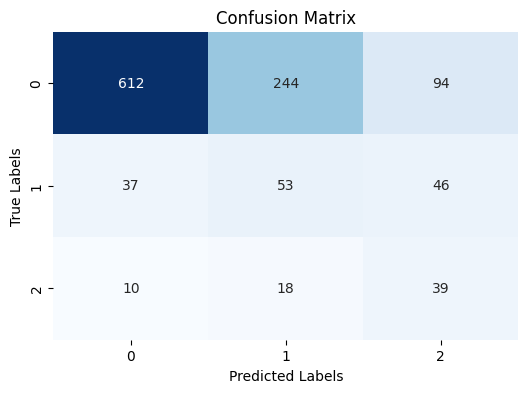


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 612/950 (64.42%)
Class 1: Correct Predictions / Total True Samples = 53/136 (38.97%)
Class 2: Correct Predictions / Total True Samples = 39/67 (58.21%)

Precision-Recall Curves:


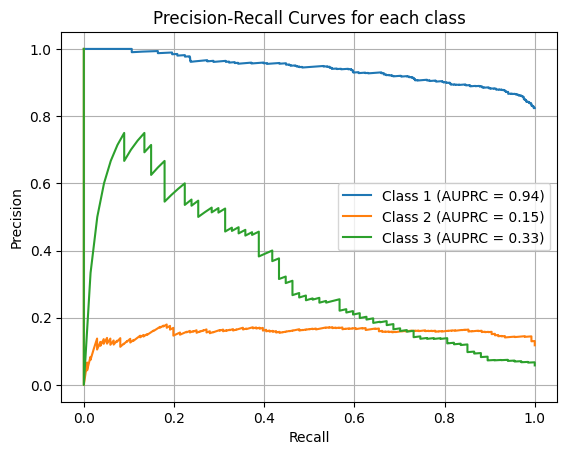


ROC Curves:


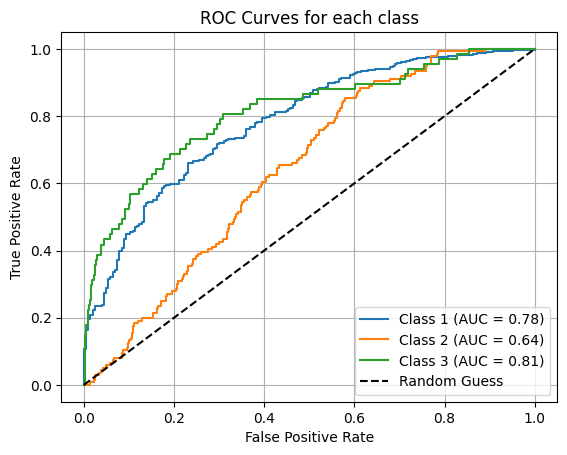


Mean F1 Score: 0.4376
Balanced Accuracy: 0.5387
Average AUPRC: 0.4745

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.64      0.76       950
           1       0.17      0.39      0.24       136
           2       0.22      0.58      0.32        67

    accuracy                           0.61      1153
   macro avg       0.44      0.54      0.44      1153
weighted avg       0.80      0.61      0.67      1153

Fold No: 2
Epoch [1/100], Loss: 1.0972, Accuracy: 0.3611
Validation Loss: 1.0850, Validation Accuracy: 0.4277
Epoch [2/100], Loss: 1.0654, Accuracy: 0.4678
Validation Loss: 0.8996, Validation Accuracy: 0.3710
Epoch [3/100], Loss: 1.0436, Accuracy: 0.5146
Validation Loss: 0.9995, Validation Accuracy: 0.4613
Epoch [4/100], Loss: 1.0399, Accuracy: 0.5190
Validation Loss: 0.9327, Validation Accuracy: 0.4808
Epoch [5/100], Loss: 1.0304, Accuracy: 0.5358
Validation Loss: 0.9096, Validation Accuracy: 0.5260
Epoch [6/100], Los

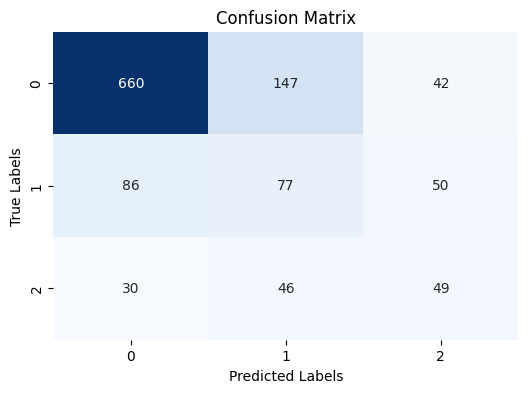


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 660/849 (77.74%)
Class 1: Correct Predictions / Total True Samples = 77/213 (36.15%)
Class 2: Correct Predictions / Total True Samples = 49/125 (39.20%)

Precision-Recall Curves:


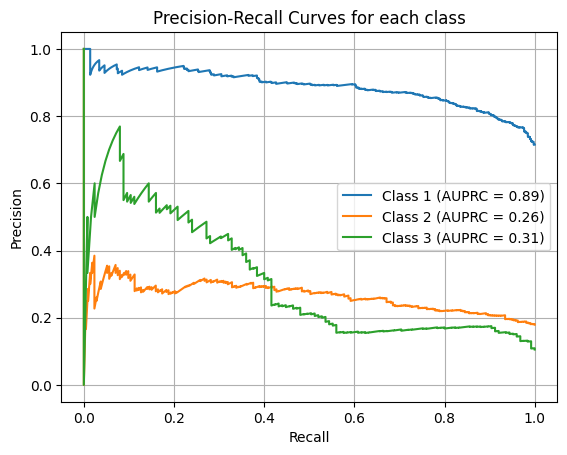


ROC Curves:


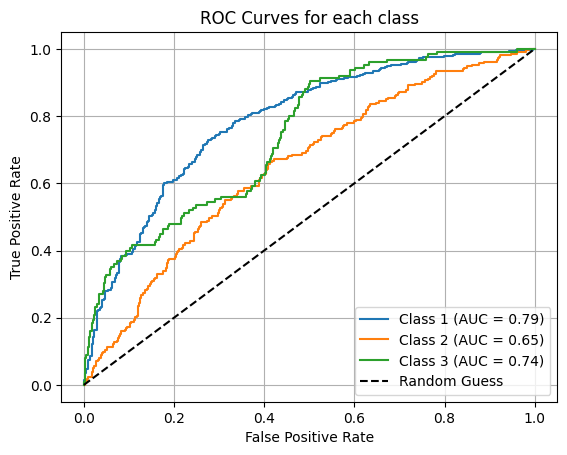


Mean F1 Score: 0.4999
Balanced Accuracy: 0.5103
Average AUPRC: 0.4859

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       849
           1       0.29      0.36      0.32       213
           2       0.35      0.39      0.37       125

    accuracy                           0.66      1187
   macro avg       0.49      0.51      0.50      1187
weighted avg       0.70      0.66      0.68      1187

Fold No: 3
Epoch [1/100], Loss: 1.0982, Accuracy: 0.3415
Validation Loss: 1.0957, Validation Accuracy: 0.3567
Epoch [2/100], Loss: 1.0899, Accuracy: 0.3845
Validation Loss: 1.0772, Validation Accuracy: 0.3934
Epoch [3/100], Loss: 1.0695, Accuracy: 0.4427
Validation Loss: 1.0003, Validation Accuracy: 0.4232
Epoch [4/100], Loss: 1.0652, Accuracy: 0.4622
Validation Loss: 1.0144, Validation Accuracy: 0.4469
Epoch [5/100], Loss: 1.0628, Accuracy: 0.4652
Validation Loss: 1.0456, Validation Accuracy: 0.4722
Epoch [6/100], Los

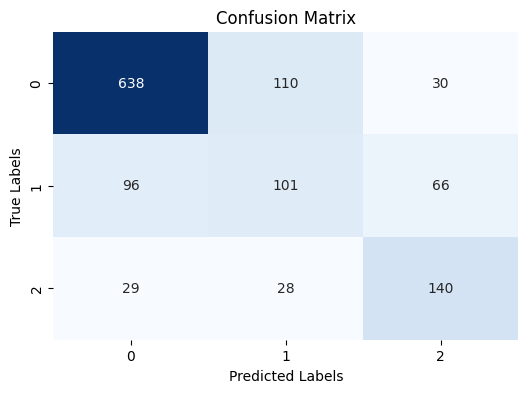


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 638/778 (82.01%)
Class 1: Correct Predictions / Total True Samples = 101/263 (38.40%)
Class 2: Correct Predictions / Total True Samples = 140/197 (71.07%)

Precision-Recall Curves:


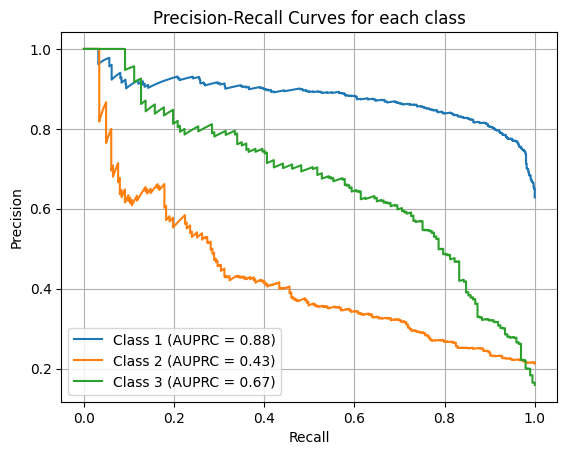


ROC Curves:


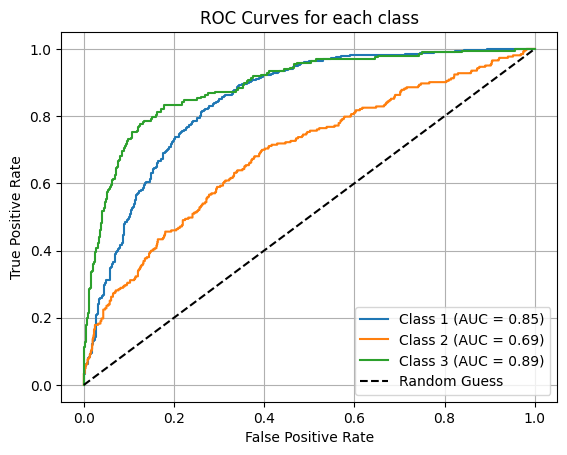


Mean F1 Score: 0.6257
Balanced Accuracy: 0.6382
Average AUPRC: 0.6571

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       778
           1       0.42      0.38      0.40       263
           2       0.59      0.71      0.65       197

    accuracy                           0.71      1238
   macro avg       0.62      0.64      0.63      1238
weighted avg       0.71      0.71      0.71      1238

Fold No: 4
Epoch [1/100], Loss: 1.0988, Accuracy: 0.3344
Validation Loss: 1.0982, Validation Accuracy: 0.3932
Epoch [2/100], Loss: 1.0981, Accuracy: 0.3676
Validation Loss: 1.0925, Validation Accuracy: 0.3973
Epoch [3/100], Loss: 1.0843, Accuracy: 0.4289
Validation Loss: 1.1022, Validation Accuracy: 0.4408
Epoch [4/100], Loss: 1.0758, Accuracy: 0.4393
Validation Loss: 1.0667, Validation Accuracy: 0.5441
Epoch [5/100], Loss: 1.0559, Accuracy: 0.4912
Validation Loss: 1.0785, Validation Accuracy: 0.4915
Epoch [6/100], Los

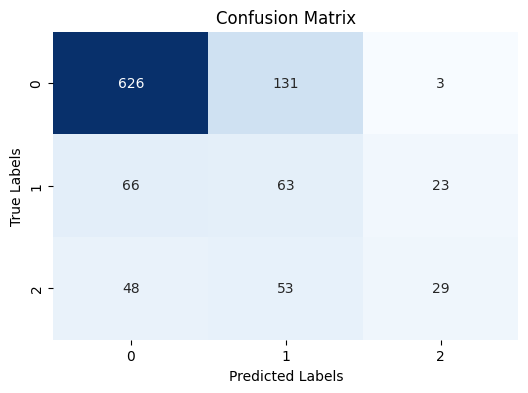


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 626/760 (82.37%)
Class 1: Correct Predictions / Total True Samples = 63/152 (41.45%)
Class 2: Correct Predictions / Total True Samples = 29/130 (22.31%)

Precision-Recall Curves:


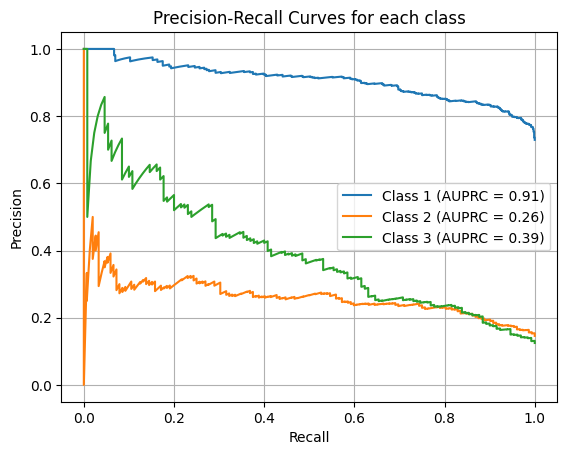


ROC Curves:


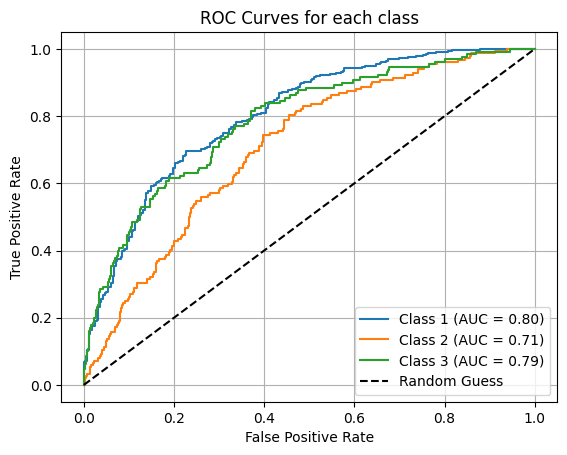


Mean F1 Score: 0.4880
Balanced Accuracy: 0.4871
Average AUPRC: 0.5193

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.83       760
           1       0.26      0.41      0.32       152
           2       0.53      0.22      0.31       130

    accuracy                           0.69      1042
   macro avg       0.54      0.49      0.49      1042
weighted avg       0.72      0.69      0.69      1042

Fold No: 5
Epoch [1/100], Loss: 1.0987, Accuracy: 0.3385
Validation Loss: 1.0959, Validation Accuracy: 0.5004
Epoch [2/100], Loss: 1.0835, Accuracy: 0.4225
Validation Loss: 1.0410, Validation Accuracy: 0.4869
Epoch [3/100], Loss: 1.0595, Accuracy: 0.4704
Validation Loss: 1.0126, Validation Accuracy: 0.5066
Epoch [4/100], Loss: 1.0452, Accuracy: 0.5184
Validation Loss: 1.0057, Validation Accuracy: 0.4884
Epoch [5/100], Loss: 1.0368, Accuracy: 0.5304
Validation Loss: 0.9200, Validation Accuracy: 0.4702
Epoch [6/100], Los

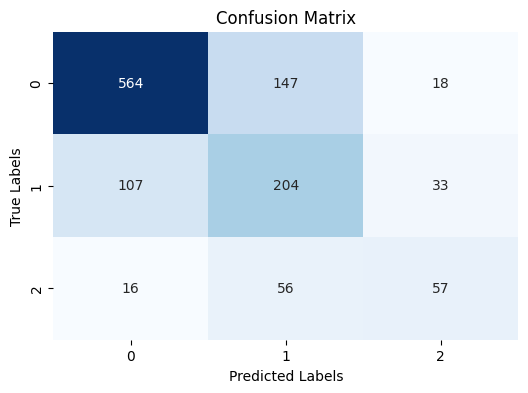


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 564/729 (77.37%)
Class 1: Correct Predictions / Total True Samples = 204/344 (59.30%)
Class 2: Correct Predictions / Total True Samples = 57/129 (44.19%)

Precision-Recall Curves:


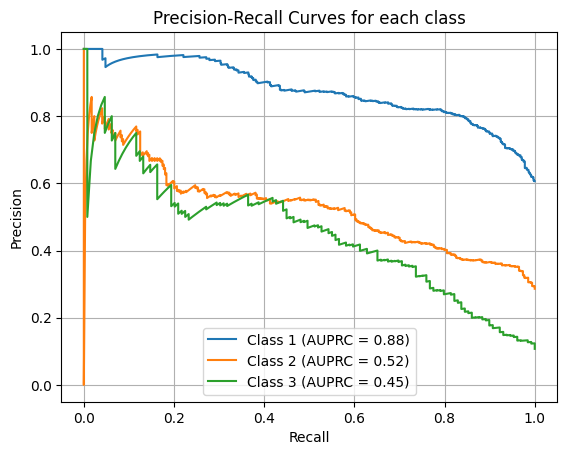


ROC Curves:


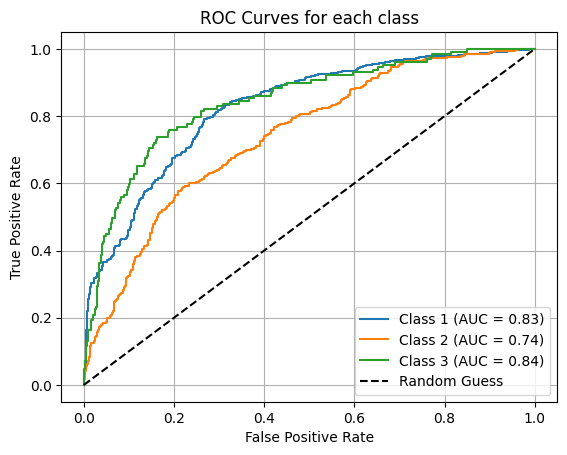


Mean F1 Score: 0.6070
Balanced Accuracy: 0.6028
Average AUPRC: 0.6163

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.77      0.80       729
           1       0.50      0.59      0.54       344
           2       0.53      0.44      0.48       129

    accuracy                           0.69      1202
   macro avg       0.62      0.60      0.61      1202
weighted avg       0.70      0.69      0.69      1202


RESULTS FOR PARAMETER SET 5
Accuracy for each fold: ['0.5387', '0.5103', '0.6382', '0.4871', '0.6028']
Average Accuracy: 0.5554
AUPRC for each fold: ['0.4745', '0.4859', '0.6571', '0.5193', '0.6163']
Average AUPRC: 0.5506
Best fold class-wise balanced accuracy: ['0.8237', '0.5930', '0.7107']


FINAL SUMMARY OF ALL 5 PARAMETER SETS

Parameter Set 1:
Parameters: {'hidden_size': 512, 'num_layers': 1, 'dropout': 0.30000000000000004, 'learning_rate': 8.41673746313518e-06, 'weight_decay': 2.671260614647494e-05, 'batch_size'

In [9]:
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc

top_params = [
    {'hidden_size': 512, 'num_layers': 1, 'dropout': 0.30000000000000004, 'learning_rate': 8.41673746313518e-06, 'weight_decay': 2.671260614647494e-05, 'batch_size': 10}, # Accuracy: 0.5649, Trial: 7
    {'hidden_size': 1024, 'num_layers': 1, 'dropout': 0.1, 'learning_rate': 3.1698115236603614e-06, 'weight_decay': 4.8990822406347735e-06, 'batch_size': 10}, # Accuracy: 0.5447, Trial: 18
    {'hidden_size': 1024, 'num_layers': 1, 'dropout': 0.30000000000000004, 'learning_rate': 4.041251088887564e-06, 'weight_decay': 5.788250075003372e-06, 'batch_size': 10}, # Accuracy: 0.5413, Trial: 17
    {'hidden_size': 1024, 'num_layers': 1, 'dropout': 0.30000000000000004, 'learning_rate': 2.553105885330496e-05, 'weight_decay': 7.720918959587612e-06, 'batch_size': 10}, # Accuracy: 0.5046, Trial: 13
    {'hidden_size': 128, 'num_layers': 4, 'dropout': 0.2, 'learning_rate': 0.00010371656791920614, 'weight_decay': 0.0002740103506586785, 'batch_size': 16}  # Accuracy: 0.4867, Trial: 11
]

# Fold indices and other configurations
num_folds = 5
fold_indices = np.random.permutation(np.arange(num_folds))
val_fold_indices = np.roll(fold_indices, 1)

# Model and training configurations
num_classes = 3
input_size = 224 * 3
epochs = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_info, learning_rate, csv_path=r"F:\CODING\py\newnotebooks\results.csv"):
    """
    Save all results from the current experiment to a CSV file
    """
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    data = {
        "timestamp": timestamp,
        "model_info": model_info,
        "num_classes": num_classes,
        "learning_rate": learning_rate,
        "epochs": epochs,
        "mean_balanced_accuracy": np.mean(fold_accuracies),
        "std_balanced_accuracy": np.std(fold_accuracies),
        "mean_auprc": np.mean(fold_auprcs),
        "std_auprc": np.std(fold_auprcs),
    }

    for i, (acc, auprc) in enumerate(zip(fold_accuracies, fold_auprcs)):
        data[f"fold_{i+1}_accuracy"] = acc
        data[f"fold_{i+1}_auprc"] = auprc

    for i, cm in enumerate(fold_confusion_matrices):
        data[f"fold_{i+1}_confusion_matrix"] = str(cm)

    df = pd.DataFrame([data])
    file_exists = os.path.isfile(csv_path)

    if file_exists:
        df.to_csv(csv_path, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_path, mode='w', header=True, index=False)

    print(f"Results saved to {csv_path}")

def calculate_class_wise_balanced_accuracy(y_true, y_pred, num_classes):
    """Calculate balanced accuracy for each class using confusion matrix approach"""
    cm = confusion_matrix(y_true, y_pred)
    class_accuracies = []
    
    for class_idx in range(num_classes):
        # Calculate class-wise accuracy: correct predictions / total true samples for this class
        correct_preds = cm[class_idx][class_idx]
        total_true_samples = sum(cm[class_idx])
        class_acc = correct_preds / total_true_samples if total_true_samples != 0 else 0
        class_accuracies.append(class_acc)
    
    return class_accuracies

# Store results for all parameter sets
all_run_results = []

# Loop through all parameter sets
for param_idx, params in enumerate(top_params):
    print(f"\n{'='*80}")
    print(f"RUNNING PARAMETER SET {param_idx + 1}/5")
    print(f"{'='*80}")
    print(f"Parameters: {params}")
    print(f"{'='*80}\n")
    
    # Extract parameters
    hidden_size = params["hidden_size"]
    num_layers = params.get("num_layers", 1)
    dropout = params["dropout"]
    learning_rate = params['learning_rate']
    weight_decay = params['weight_decay']
    batch_size = params['batch_size']
    
    # Initialize lists for this parameter set
    fold_accuracies = []
    fold_auprcs = []
    fold_confusion_matrices = []
    fold_class_wise_accuracies = []
    test_folds_chosen = []
    val_folds_chosen = []

    # Training loop for cross-validation
    for fold_idx in range(num_folds):
        print(f'Fold No: {fold_idx + 1}')

        # Initialize model, loss, and optimizer
        fold_model = LstmAttention(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            num_classes=num_classes,
            dropout=dropout
        ).to(device)

        criterion = nn.CrossEntropyLoss(label_smoothing=0.3)
        optimizer = optim.Adam(fold_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        # Split data into train, validation, and test sets
        test_fold = fold_indices[fold_idx]
        val_fold = val_fold_indices[fold_idx]
        train_folds = [fold for fold in fold_indices if fold != test_fold and fold != val_fold]

        train_data = np.concatenate([eeg_folds[j] for j in train_folds])
        train_labels = np.concatenate([labels_folds[j] for j in train_folds])
        train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], train_data.shape[2]*train_data.shape[3]))

        test_folds_chosen.append(test_fold)
        val_folds_chosen.append(val_fold)

        early_stopping = EarlyStopping(patience=10)

        # Training loop
        for epoch in range(epochs):
            balanced_train_data, balanced_train_labels = data_balancer(train_data, train_labels, factor=1)

            train_dataset = TensorDataset(
                torch.tensor(balanced_train_data, dtype=torch.float32).to(device),
                torch.tensor(balanced_train_labels, dtype=torch.long).to(device)
            )
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            fold_model.train()
            running_loss = 0.0
            all_preds = []
            all_labels = []

            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = fold_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(train_loader)
            epoch_acc = balanced_accuracy_score(all_labels, all_preds)
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

            # Validation loop
            val_data = eeg_folds[val_fold]
            val_data = val_data.reshape((val_data.shape[0], val_data.shape[1], val_data.shape[2]*val_data.shape[3]))
            val_labels = labels_folds[val_fold]
            val_dataset = TensorDataset(
                torch.tensor(val_data, dtype=torch.float32).to(device),
                torch.tensor(val_labels, dtype=torch.long).to(device)
            )
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            fold_model.eval()
            val_loss = 0.0
            val_preds = []
            val_labels_list = []

            with torch.no_grad():
                for val_inputs, val_labels_batch in val_loader:
                    val_outputs = fold_model(val_inputs)
                    loss = criterion(val_outputs, val_labels_batch)
                    val_loss += loss.item()

                    _, val_batch_preds = torch.max(val_outputs, 1)
                    val_preds.extend(val_batch_preds.cpu().numpy())
                    val_labels_list.extend(val_labels_batch.cpu().numpy())

            val_loss /= len(val_loader)
            val_acc = balanced_accuracy_score(val_labels_list, val_preds)
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

            early_stopping(val_loss, fold_model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        # Load the best model
        early_stopping.load_best_model(fold_model)

        # Test loop
        test_data = eeg_folds[test_fold]
        test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], test_data.shape[2]*test_data.shape[3]))
        test_labels = labels_folds[test_fold]
        test_dataset = TensorDataset(
            torch.tensor(test_data, dtype=torch.float32).to(device),
            torch.tensor(test_labels, dtype=torch.long).to(device)
        )
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        fold_model.eval()
        test_probs = []
        test_preds = []
        test_labels_list = []

        with torch.no_grad():
            for test_inputs, test_labels_batch in test_loader:
                test_outputs = fold_model(test_inputs)
                probabilities = torch.softmax(test_outputs, dim=1)
                test_probs.extend(probabilities.cpu().numpy())
                _, preds = torch.max(probabilities, 1)
                test_preds.extend(preds.cpu().numpy())
                test_labels_list.extend(test_labels_batch.cpu().numpy())

        # Compute metrics
        test_acc = balanced_accuracy_score(test_labels_list, test_preds)
        fold_accuracies.append(test_acc)

        cm = confusion_matrix(test_labels_list, test_preds)
        fold_confusion_matrices.append(cm)

        # Calculate class-wise balanced accuracy
        class_wise_acc = calculate_class_wise_balanced_accuracy(np.array(test_labels_list), np.array(test_preds), num_classes)
        fold_class_wise_accuracies.append(class_wise_acc)

        test_labels_binarized = label_binarize(test_labels_list, classes=np.arange(num_classes))
        test_auprcs = []
        for class_idx in range(num_classes):
            precision, recall, _ = precision_recall_curve(test_labels_binarized[:, class_idx], np.array(test_probs)[:, class_idx])
            auprc = auc(recall, precision)
            test_auprcs.append(auprc)

        mean_test_auprc = np.mean(test_auprcs)
        fold_auprcs.append(mean_test_auprc)

        print(f'Test Fold {fold_idx + 1}, Mean AUPRC: {mean_test_auprc:.4f}, Balanced Accuracy: {test_acc:.4f}')
        print(f'Class-wise Balanced Accuracy: {[f"{acc:.4f}" for acc in class_wise_acc]}')

        # Use the plot_metrics function to visualize metrics
        plot_metrics(np.array(test_labels_list), np.array(test_probs), n_classes=num_classes)

    # Calculate best fold class-wise balanced accuracy
    fold_class_wise_accuracies = np.array(fold_class_wise_accuracies)
    best_fold_class_wise = np.max(fold_class_wise_accuracies, axis=0)

    # Final metrics across all folds for this parameter set
    average_auprc = np.mean(fold_auprcs)
    mean_accuracy = np.mean(fold_accuracies)
    
    print(f"\n{'='*60}")
    print(f"RESULTS FOR PARAMETER SET {param_idx + 1}")
    print(f"{'='*60}")
    print(f'Accuracy for each fold: {[f"{acc:.4f}" for acc in fold_accuracies]}')
    print(f'Average Accuracy: {mean_accuracy:.4f}')
    print(f'AUPRC for each fold: {[f"{auprc:.4f}" for auprc in fold_auprcs]}')
    print(f'Average AUPRC: {average_auprc:.4f}')
    print(f'Best fold class-wise balanced accuracy: {[f"{acc:.4f}" for acc in best_fold_class_wise]}')
    print(f"{'='*60}\n")
    
    # Store results for final summary
    run_result = {
        'param_set': param_idx + 1,
        'params': params,
        'fold_accuracies': fold_accuracies,
        'average_accuracy': mean_accuracy,
        'fold_auprcs': fold_auprcs,
        'average_auprc': average_auprc,
        'best_fold_class_wise_accuracy': best_fold_class_wise
    }
    all_run_results.append(run_result)
    

# Final summary of all runs
print(f"\n{'='*80}")
print(f"FINAL SUMMARY OF ALL 5 PARAMETER SETS")
print(f"{'='*80}")

for result in all_run_results:
    print(f"\nParameter Set {result['param_set']}:")
    print(f"Parameters: {result['params']}")
    print(f"Accuracy for each fold: {[f'{acc:.4f}' for acc in result['fold_accuracies']]}")
    print(f"Average Accuracy: {result['average_accuracy']:.4f}")
    print(f"AUPRC for each fold: {[f'{auprc:.4f}' for auprc in result['fold_auprcs']]}")
    print(f"Average AUPRC: {result['average_auprc']:.4f}")
    print(f"Best fold class-wise balanced accuracy: {[f'{acc:.4f}' for acc in result['best_fold_class_wise_accuracy']]}")
    print("-" * 60)

print(f"{'='*80}")
